# All In One Place
---

## PLANNING

    All In One Place Co. is a multi-brand company that seeks to sell various products at a competitive price and quality assurance. Recently, the marketing team discovered in database that some customers were buying more expensive products frequently. 
    Knowing this, the All In One Place team create a plan to develop a loyalty program for customers, the idea of the Insiders was created. Even with that information, the team isn't sure which customers will be assigned to the program, so the data team was called to cooperate. 
    It is up to the data team to answer the following questions: 
   - Who are the elegible people to participate in the “Insiders Program”?
   - How many clients will be part of the group?
   - Which are the main caracteristics for the group?
   - What is the revenue percentage that comes from the group?
   - Which are the guarantees that the “Insiders Program” is better than the rest of the base?

### Tasks

1. Identify elegible costumers for Insiders?
    - How can a costumer become eligible? What is a High-Value costumer?
        - **Revenue**:
            - High ticket
            - High LT revenue
            - Low recency
            - High bascket size
            - Low churn probability
            - High revenue forecast
            - High probabilty of pruchase

        - **Cost**:
            - Low return rate

        - **Costumer experience**:
            - High rating
    
2. How many costumers will be included into Insiders?
    - Total customers
    - Rate (%) of members to include in Insiders
        
3. Which are the main characteristics of those costumers?
    - Describe the customers attributes:
        - Age
        - Localization
     
    - Consumption behavior:
        - Same attributes for clustering
        
4. Which is the revenue of Insiders?
    - Total revenue
    - Revenue of Insiders members

5. Which is the revenue forecast for next months of Insiders?
    - LT revenue of Insiders members
    - Cohort analysis

6. What are the conditions to be included in Insiders?
    - Define the period of evualation (1 month, 3 months,...)
    - New members must have similar attributes of current members

7. What are the conditions to be removed in Insiders?
    - Define the period of evualation (1 month, 3 months,...)
    - Members to be removed must have different attributes of group

8. How can we garantee the Insiders program is better than others costumers?
    - A/B Test
    - A/B Bayesian
    - Hypothesis test

9. How can Marketing Dept. increase the revenue?
    - Discount
    - Purchase preference
    - Free freight
    - Company tour

### Benchmark

1. RFM Model
     - Recency
          - Time since the last purchase.
          - Responsivity.
           
     - Frequency
          - Avg time between transactions.
          - Engagement
            
      - Monetary
          - Gross revenues.
          - High value purchases.

## IMPORTS

In [1]:
import pickle
import warnings
import inflection

import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import umap.umap_               as umap
import matplotlib.pyplot        as plt
import matplotlib.ticker        as ticker

from pandas_profiling                       import ProfileReport
from IPython.core.display                   import HTML
from IPython.core.display                   import Image
from datetime                               import timedelta

import sklearn.preprocessing    as pp
from sklearn.cluster                        import KMeans
from sklearn.metrics                        import silhouette_score
from yellowbrick.cluster                    import KElbowVisualizer, SilhouetteVisualizer

## HELPER FUNCTIONS

Numerical

In [2]:
def numerical_metrics(numerical_attributes):
    """Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        numerical_attributes ([float64 and int64]): Insert all numerical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range
    """
    
    
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(numerical_attributes.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','Q1','Q3', 'St deviation','Skewness','Kurtosis']

    return num_attributes

Graphic

In [3]:
def plot_label(title, xlabel, ylabel, fontsize):
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    sns.set_context('notebook')


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


Config

In [4]:
# snakecase
def snakecase(cols):
    change_snakecase = lambda x: inflection.underscore(x)
    return list(map(change_snakecase, cols))


def sum_of_na(data):
    return pd.DataFrame({'Sum of NA': data.isna().sum(), '% NA': data.isna().sum()/data.shape[0]})


# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.3f}'.format

seed = 42

## DATA

This dataset is avaliable in: https://www.kaggle.com/vik2012kvs/high-value-customers-identification

- **Data fields**
    - Invoice Number: Unique value from every transaction
    - Stock Code Product: Product code
    - Description: Product name
    - Quantity: The quantities of each product per transaction
    - Invoice Date: The day when the transaction was generated
    - Unit Price: Product price per unit
    - Customer ID: Unique ID to each customer
    - Country: Country name

In [5]:
homepath = '/home/gutto/Projects/pa005_insiders_clustering/insiders_clustering/'

In [6]:
df_raw = pd.read_csv(homepath + 'data/raw/Ecommerce.csv', low_memory = False)

In [7]:
pickle.dump(df_raw, open(homepath + 'data/processed/df_raw.pkl', 'wb'))

## 1. DATA DESCRIPTION

- **Tasks**
    - Dataset Checkpoint
    - Check Data
    - Rename Columns
    - Data Dimensions
    - Data Types
    - Descriptive Statistics

### 1.1 Dataset Checkpoint

In [8]:
df1 = pickle.load(open(homepath + 'data/processed/df_raw.pkl', 'rb'))

In [9]:
df1.head().T

,0,1,2,3,4
InvoiceNo,536365,536365,536365,536365,536365
StockCode,85123A,71053,84406B,84029G,84029E
Description,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER,KNITTED UNION FLAG HOT WATER BOTTLE,RED WOOLLY HOTTIE WHITE HEART.
Quantity,6,6,8,6,6
InvoiceDate,29-Nov-16,29-Nov-16,29-Nov-16,29-Nov-16,29-Nov-16
UnitPrice,2.550,3.390,2.750,3.390,3.390
CustomerID,17850.000,17850.000,17850.000,17850.000,17850.000
Country,United Kingdom,United Kingdom,United Kingdom,United Kingdom,United Kingdom
Unnamed: 8,NaN,NaN,NaN,NaN,NaN


### 1.2 Organizing Columns

In [10]:
# changing to snakecase type
cols_new = snakecase(df1.columns)
df1.columns = cols_new

### 1.3 Data Dimensions

In [11]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 541909 
Number of columns: 9


### 1.4 Check Data

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
 8   unnamed: 8    0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [13]:
sum_of_na(df1)

,Sum of NA,% NA
invoice_no,0,0.000
stock_code,0,0.000
description,1454,0.003
quantity,0,0.000
invoice_date,0,0.000
unit_price,0,0.000
customer_id,135080,0.249
country,0,0.000
unnamed: 8,541909,1.000


The unnamed: 8 is empty in all rows, so I will drop that

### 1.5 Deal with NA

In [14]:
df1.drop(['unnamed: 8'], axis = 1, inplace = True)

In [15]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [16]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra column
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,United Kingdom,17850.000
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,United Kingdom,17850.000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,United Kingdom,17850.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,United Kingdom,17850.000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,United Kingdom,17850.000


In [17]:
sum_of_na(df1)

,Sum of NA,% NA
invoice_no,0,0.000
stock_code,0,0.000
description,1454,0.003
quantity,0,0.000
invoice_date,0,0.000
unit_price,0,0.000
country,0,0.000
customer_id,0,0.000


### 1.6 Unique values

In [18]:
print(f'There are {len(df1["invoice_no"].unique())} unique invoice numbers.')
print(f'There are {len(df1["stock_code"].unique())} diferent unique stock codes.')
print(f'There are {len(df1["description"].unique())} unique products descriptions.')
print(f'There are {len(df1["customer_id"].unique())} unique customers.')

There are 25900 unique invoice numbers.
There are 4070 diferent unique stock codes.
There are 4224 unique products descriptions.
There are 8082 unique customers.


### 1.7 Data Types

In [19]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

I've found some weird values in invoice_no column, some rows has a letter, like: C536479

1. `invoice_date`: Need to be converted from object to datetime64

In [20]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

2. `customer`: Need to be converted from float64 to int64

In [21]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [22]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.8 Ordering Columns

In [23]:
df1 = df1.reindex(columns=['customer_id', 'invoice_date', 'stock_code', 'description', 'unit_price', 'quantity', 'country', 'invoice_no'])
df1.head()

,customer_id,invoice_date,stock_code,description,unit_price,quantity,country,invoice_no
0,17850,2016-11-29,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.550,6,United Kingdom,536365
1,17850,2016-11-29,71053,WHITE METAL LANTERN,3.390,6,United Kingdom,536365
2,17850,2016-11-29,84406B,CREAM CUPID HEARTS COAT HANGER,2.750,8,United Kingdom,536365
3,17850,2016-11-29,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.390,6,United Kingdom,536365
4,17850,2016-11-29,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.390,6,United Kingdom,536365


### 1.9 Descriptive Statistics

#### 1.9.1 Numerical Attributes

In [24]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(columns='customer_id')
num_cols = num_attributes.columns.tolist()

In [25]:
num_attributes_result = numerical_metrics(num_attributes[num_cols])
num_attributes_result

,Attributes,Min,Max,Range,Mean,Median,Q1,Q3,St deviation,Skewness,Kurtosis
0,unit_price,-11062.060,38970.000,50032.060,4.611,2.080,1.250,4.130,96.760,186.507,59005.719
1,quantity,-80995.000,80995.000,161990.000,9.552,3.000,1.000,10.000,218.081,-0.264,119769.160


`Outliers in unit price and quantity`:

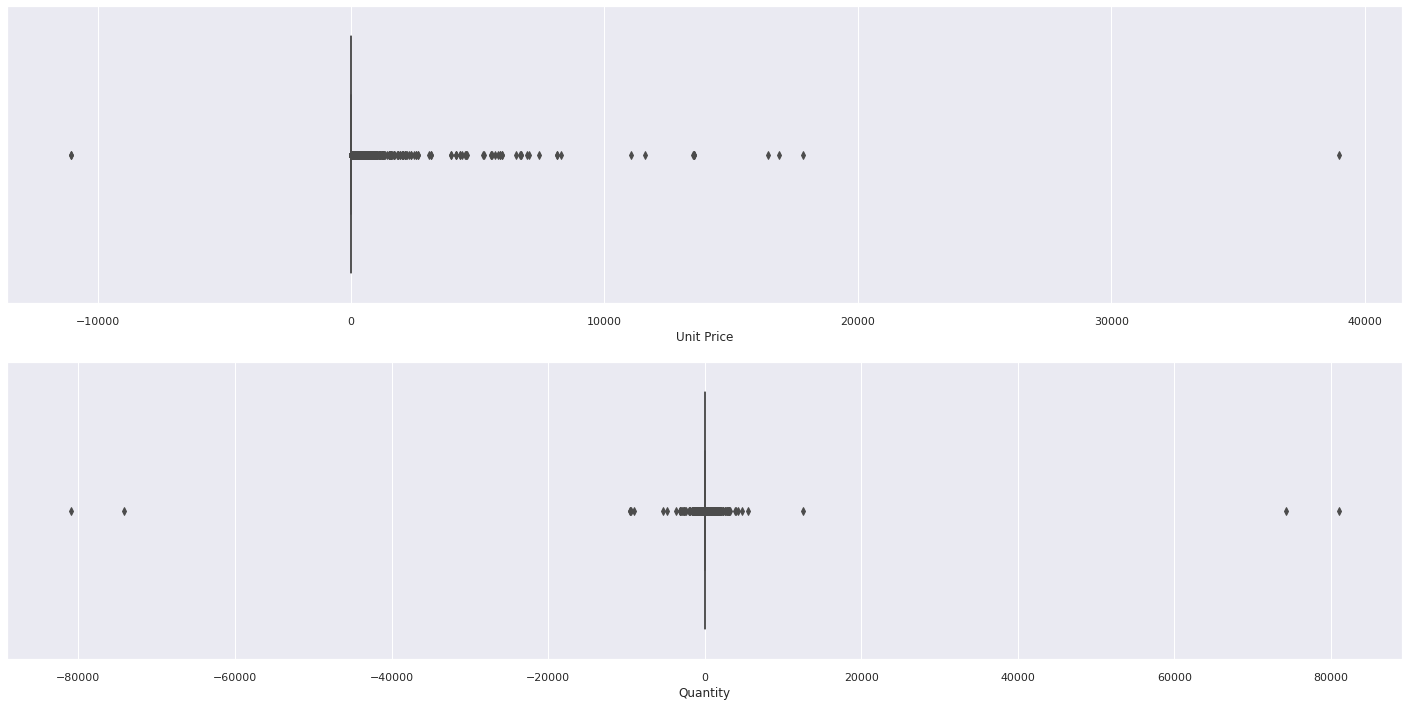

In [26]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

ax = sns.boxplot(df1['unit_price'], ax = ax1);
ax.set_xlabel('Unit Price', fontsize = 12);
ax = sns.boxplot(df1['quantity'], ax = ax2);
ax.set_xlabel('Quantity', fontsize = 12);

#saving figure
plt.savefig(homepath + 'reports/figures/num_attributes_outliers.png')

##### 1.9.1.1 Numerical Attributes Investigation

1. `Negative Quantity`: It could be devolutions
2. `Unit Price equal to 0`: Promotion?

#### 1.9.2 Categorical Attributes

1. `invoice_no`:

In [27]:
df_invoice_letter = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_invoice_letter.head()
print(f"Total number of invoices: {len(df_invoice_letter)}")
print(f"Total number of negative quantity: {len(df_invoice_letter[df_invoice_letter['quantity'] < 0])}")

Total number of invoices: 9291
Total number of negative quantity: 9288


2. `stock_code`:

In [28]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

3. `country`:

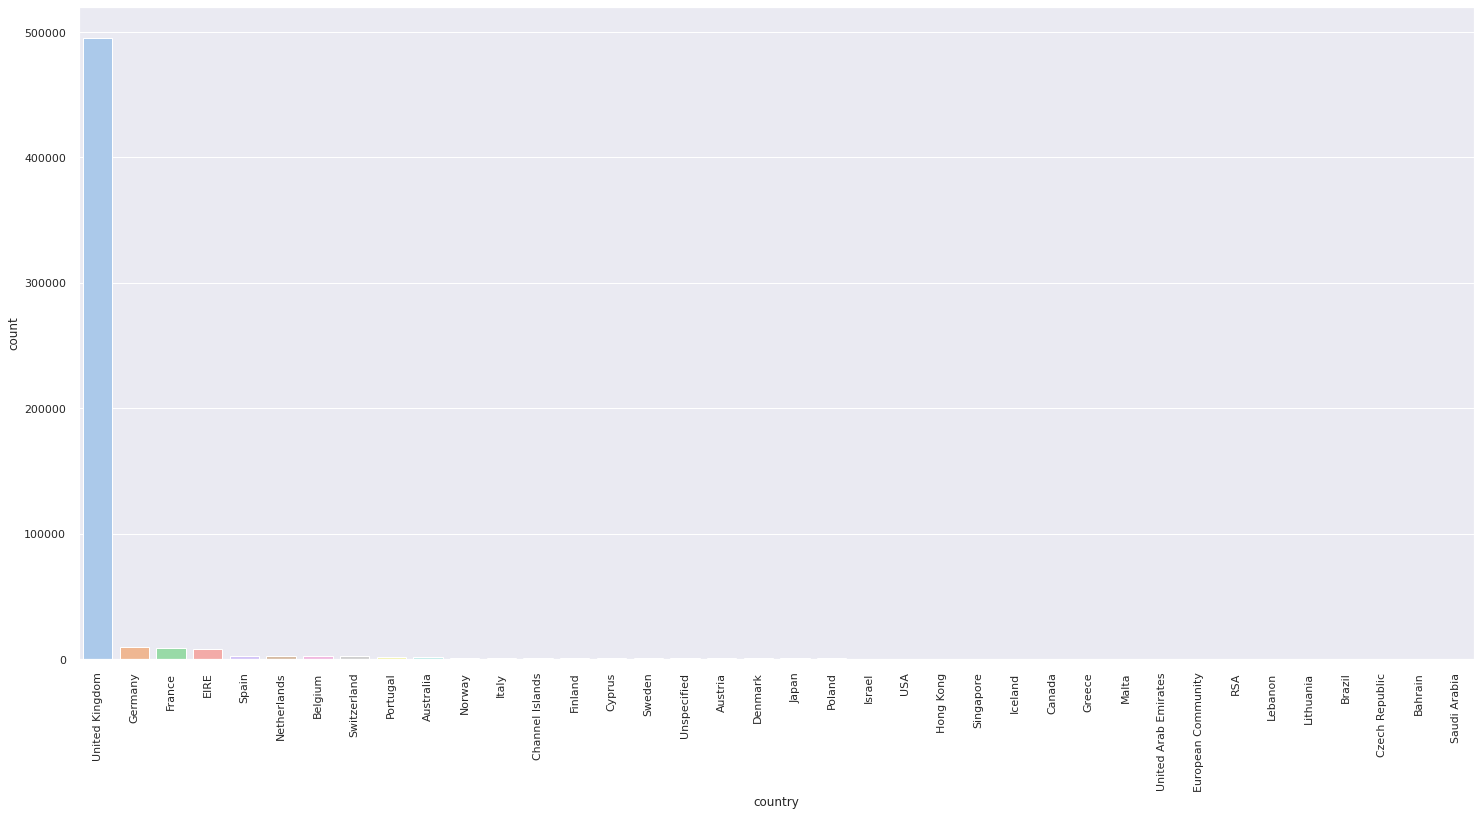

In [29]:
ax = sns.countplot(x = 'country', data = df1, palette = 'pastel', order = df1['country'].value_counts().index)
plt.xticks(rotation = 90);

# saving figure
plt.savefig(homepath + 'reports/figures/country_count_uk.png')

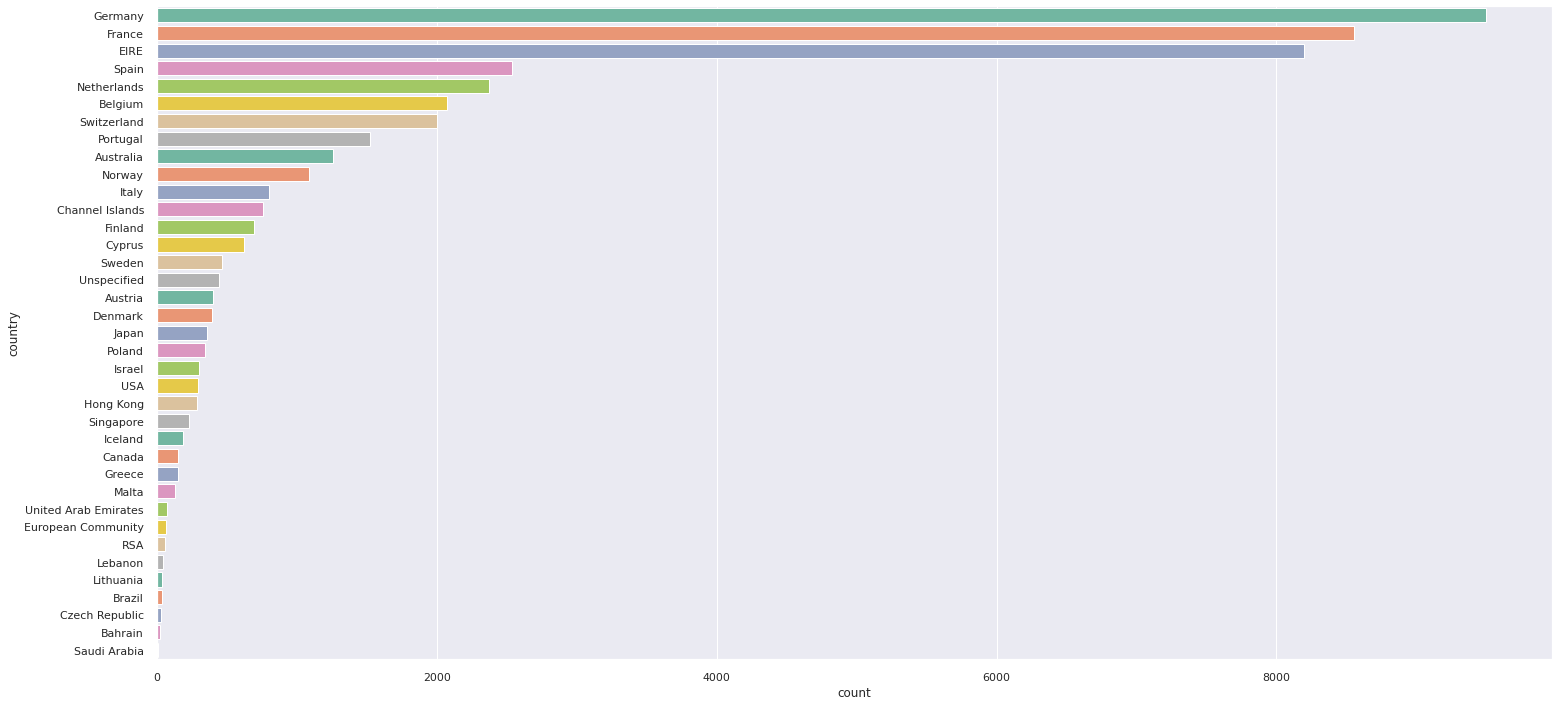

In [30]:
aux1 = df1[df1['country'] != 'United Kingdom']
aux2 = aux1[aux1['country'] != 'Unspecified']
ax = sns.countplot(y = 'country', data = aux1, palette = 'Set2', order = aux1['country'].value_counts().index)

# saving figure
plt.savefig(homepath + 'reports/figures/country_count.png')

#### 1.9.3 Date Attributes

In [31]:
print(f'First purchase: {df1["invoice_date"].min()}.')
print(f'Last purchase: {df1["invoice_date"].max()}.')

First purchase: 2016-11-29 00:00:00.
Last purchase: 2017-12-07 00:00:00.


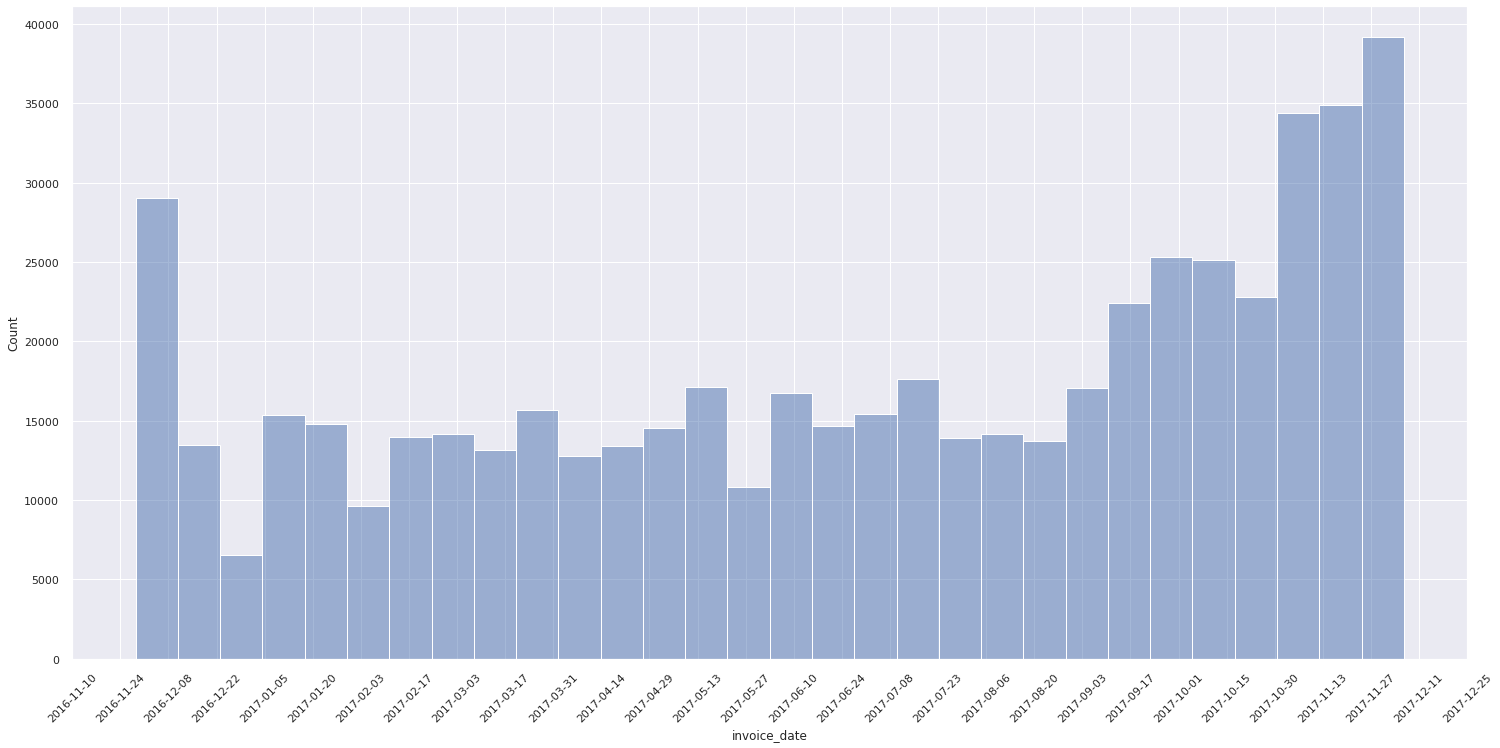

In [32]:
ax = sns.histplot(data = df1, x = 'invoice_date',bins = 30, alpha = 0.5);
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks = 30))

# saving figure
plt.savefig(homepath + 'reports/figures/countplot_date.png')

### 1.10 Save State

In [33]:
pickle.dump(df1, open(homepath + 'data/processed/df1.pkl', 'wb'))

## 2. VARIABLE FILTERING

- **Tasks**
    - Dataset Checkpoint
    - Filtering Rows
    - Save State

### 2.1 Dataset Checkpoint

In [34]:
df2 = pickle.load(open(homepath + 'data/processed/df1.pkl', 'rb'))

### 2.2 Filtering Rows and Columns

In [35]:
quantity_low = len(df2[df2['quantity'] < 1])
unit_price_low = len(df2[df2['unit_price'] <= 0])
print(f'There are {quantity_low} rows with product quantities in the cart less than 1 and {unit_price_low} rows with price equal or lower than 0')

There are 10624 rows with product quantities in the cart less than 1 and 2517 rows with price equal or lower than 0


Filtering `unit_price`, `quantity`,`stock_code`, `description`, `country`:

In [36]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# quantity
df_returns = df2.loc[df1['quantity'] < 0, :]
df_purchases = df2.loc[df1['quantity'] >= 0, :]

# stock_code
df2 = df2[ ~ df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis=1)

# country 
df2 = df2[ ~ df2['country'].isin(['European Community', 'Unspecified' ])]

### 2.3 Save State

In [37]:
pickle.dump(df2, open(homepath + 'data/processed/df2.pkl', 'wb'))
pickle.dump(df_returns, open(homepath + 'data/processed/df_returns.pkl', 'wb'))
pickle.dump(df_purchases, open(homepath + 'data/processed/df_purchases.pkl', 'wb'))

## 3. FEATURE ENGINEERING

- **Tasks**
    - Dataset Checkpoint
    - Features
    - Save State

### 3.1 Dataset Checkpoint

In [38]:
df3 = pickle.load(open(homepath + 'data/processed/df2.pkl', 'rb'))

### 3.2 Features

1. Creating a reference dataframe:

In [39]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 
                   'unit_price'], axis = 1).drop_duplicates(ignore_index=True)

2. Creating `gross_revenue`:

In [40]:
df_purchases.loc[:, 'gross_revenue'] = df_purchases.loc[:, 'quantity'] * df_purchases.loc[:, 'unit_price']

3. Creating `recency` - last day purchase:

In [41]:
df_recency = df_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(['invoice_date'], axis = 1, inplace = True)

# merge
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

4. Creating `frequency`:

In [42]:
df_freq = df_purchases.loc[:, ['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index()
df_freq.columns = ['customer_id', 'frequency']

# merge
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')

5. Creating `monetary`:

In [43]:
df_monetary = df_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.columns = ['customer_id', 'monetary']

# merge
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')

6. Creating `avg_ticket`:

In [44]:
# avg_ticket
df_avg_ticket = df_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_avg_ticket.columns = ['customer_id', 'avg_ticket']

# merge
df_ref = pd.merge( df_ref, df_avg_ticket, on = 'customer_id', how = 'left')

7. Creating `quantity_of_purchases`:

In [45]:
df_qop = df_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qop.columns = ['customer_id', 'quantity_of_purchases']

# merge
df_ref = pd.merge(df_ref, df_qop, on = 'customer_id', how = 'left')

8. Creating `quantity_of_products_purchased`:

In [46]:
df_qopp = df_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').count().reset_index()
df_qopp.columns = ['customer_id', 'quantity_of_products_purchased']

# merge
df_ref = pd.merge(df_ref, df_qopp, on = 'customer_id', how = 'left')

9. Creating `purchase_frequency`:

In [47]:
df_pfreq = (df_purchases.loc[:,['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                                .agg( max_ = ('invoice_date', 'max'),
                                                                                      min_ = ('invoice_date', 'min'),
                                                                                      days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                                      buy_ = ('invoice_no', 'count')
                                                                                    )).reset_index()

# calculation
df_pfreq['purchase_frequency'] = df_pfreq[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 
                                                                                       else 0, axis = 1)
df_pfreq = df_pfreq[['customer_id', 'purchase_frequency']]

# merge
df_ref = pd.merge(df_ref, df_pfreq, on = 'customer_id', how = 'left')

10. Creating `number_of_returns`:

In [48]:
df_qreturns = df_returns.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_qreturns.columns = ['customer_id', 'quantity_of_returns']
df_qreturns['quantity_of_returns'] = df_qreturns['quantity_of_returns'] * -1

# merge
df_ref = pd.merge(df_ref, df_qreturns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['quantity_of_returns'].isna(), 'quantity_of_returns'] = 0

11. Creating `basket_size`:

In [49]:
df_basket_size = (df_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                                 .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                       n_products=( 'quantity', 'sum') 
                                                                                      )).reset_index()

# calculation
df_basket_size['avg_basket_size'] = df_basket_size['n_products'] / df_basket_size['n_purchase']
df_basket_size = df_basket_size[['customer_id', 'avg_basket_size']]


# merge
df_ref = pd.merge( df_ref, df_basket_size, how='left', on='customer_id' )

12. Creating `unique_basket_size`:

In [50]:
df_ubasket_size = (df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                                   .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                         n_products=( 'stock_code', 'count') 
                                                                                       )).reset_index()

# calculation
df_ubasket_size['avg_unique_basket_size'] = df_ubasket_size['n_products'] / df_ubasket_size['n_purchase']

df_ubasket_size = df_ubasket_size[['customer_id', 'avg_unique_basket_size']]

# merge
df_ref = pd.merge( df_ref, df_ubasket_size, how='left', on='customer_id' )

13. Creating `invoice_year`, `invoice_month`, `invoice_day`:

In [51]:
df_date = df_purchases.loc[:, ['customer_id', 'invoice_date']]

# year
df_date['invoice_year'] = df_date.loc[:, 'invoice_date'].dt.year

# month
df_date['invoice_month'] = df_date.loc[:, 'invoice_date'].dt.month

# day
df_date['invoice_week'] = df_date.loc[:, 'invoice_date'].dt.dayofweek

df_date.drop(['invoice_date'], axis = 1, inplace = True)
df_ref = pd.merge(df_ref, df_date, on = 'customer_id', how = 'left')


### 3.3 Check Features NA

In [52]:
sum_of_na(df_ref)

,Sum of NA,% NA
customer_id,0,0.000
country,0,0.000
recency,90,0.000
frequency,90,0.000
monetary,90,0.000
avg_ticket,90,0.000
quantity_of_purchases,90,0.000
quantity_of_products_purchased,90,0.000
purchase_frequency,90,0.000
quantity_of_returns,0,0.000


In [53]:
df_ref = df_ref.dropna()

### 3.4 Save State

In [54]:
pickle.dump(df_ref, open(homepath + 'data/processed/df3.pkl', 'wb'))

## 4.0 EXPLORATORY DATA ANALYSIS

- **Tasks**
    - Mind Map
    - Univariate Analysis
    - Bivariate Analysis
    - Multivariate Analysis

### 4.1 Dataset Checkpoint

In [55]:
df4 = pickle.load(open(homepath + 'data/processed/df3.pkl', 'rb'))

### 4.2 Mind Map

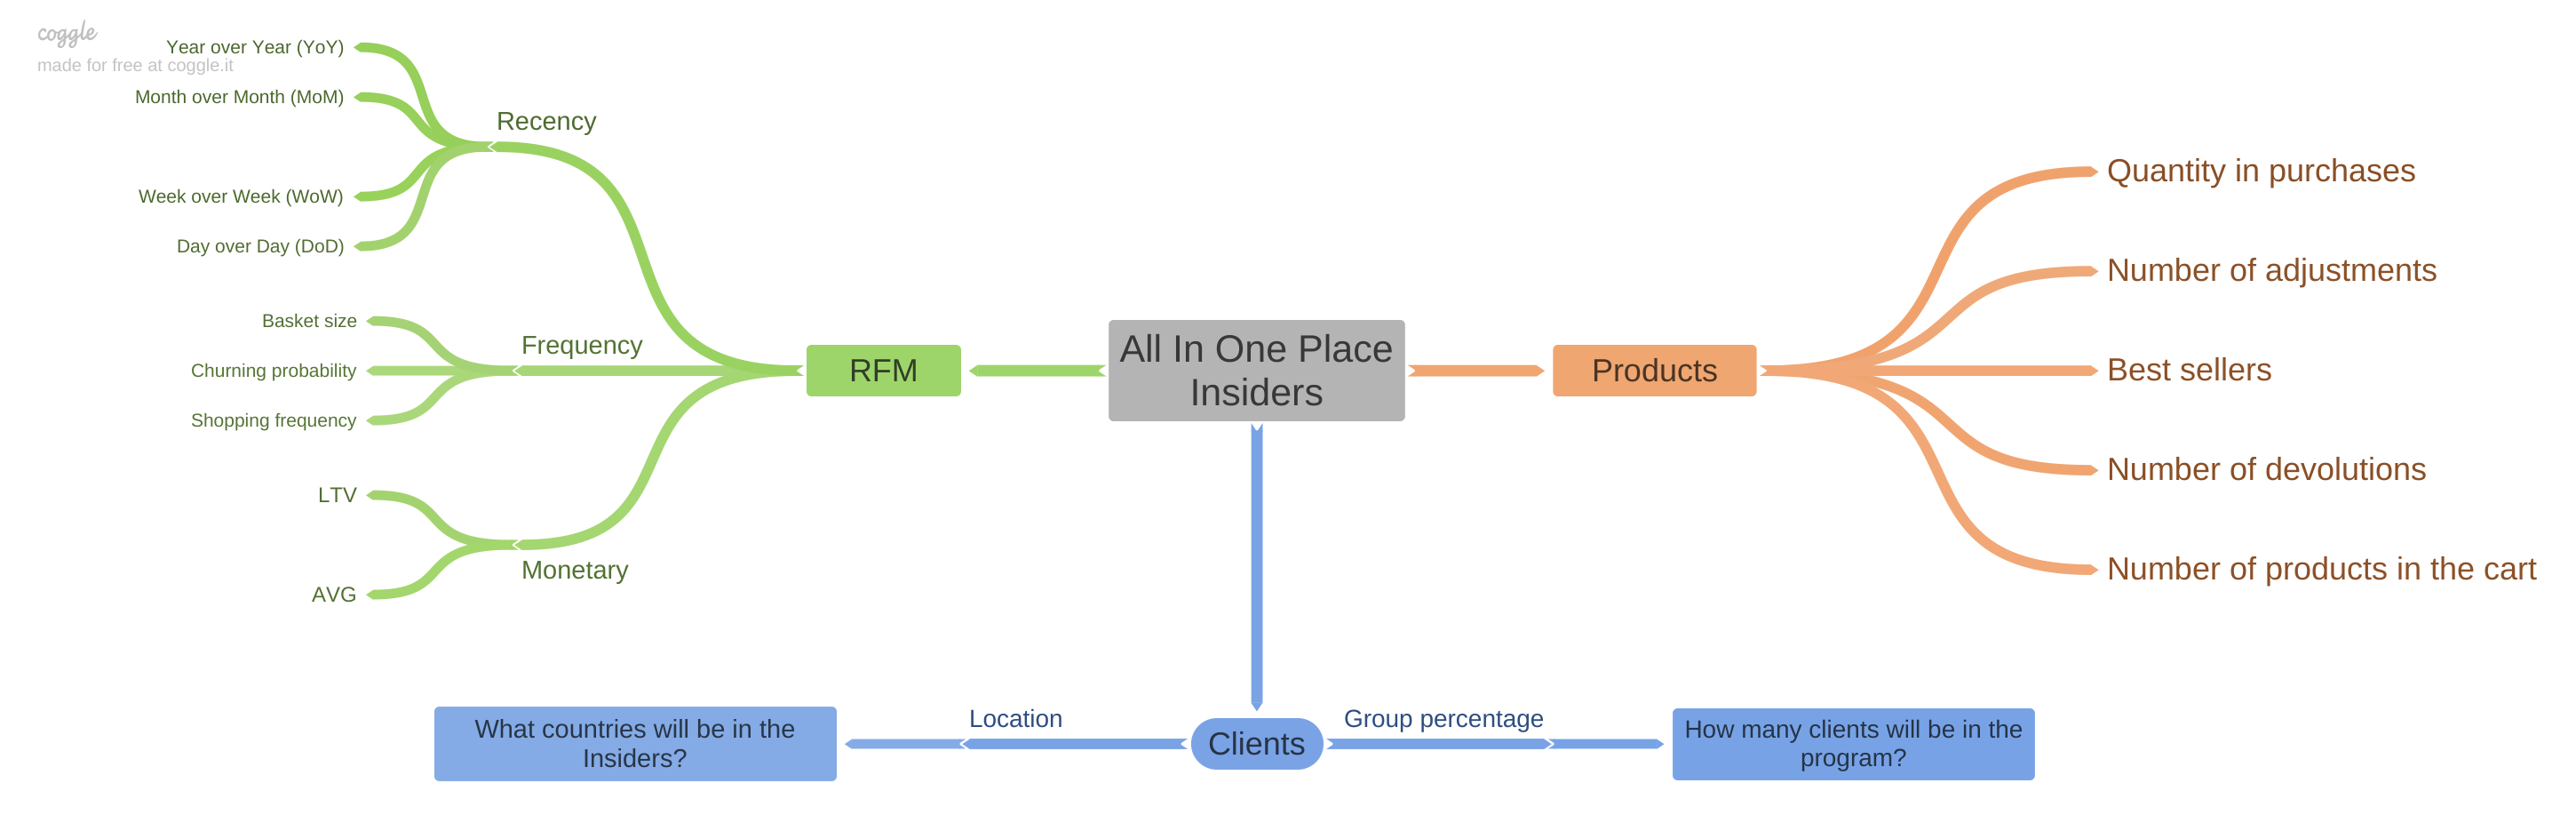

In [56]:
Image(homepath + 'reports/figures/mind_map.png')

### 4.3 Univariate Analysis

#### 4.3.1 PPR

In [57]:
df4 = df4.drop_duplicates()

In [58]:
# Pandas Proffiling Report
ppr1 = ProfileReport(df4, 'Insiders Program First Report.')
ppr1.to_file(output_file = homepath + 'reports/ppr1.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 362.01it/s]


#### 4.3.2 Invoice Week

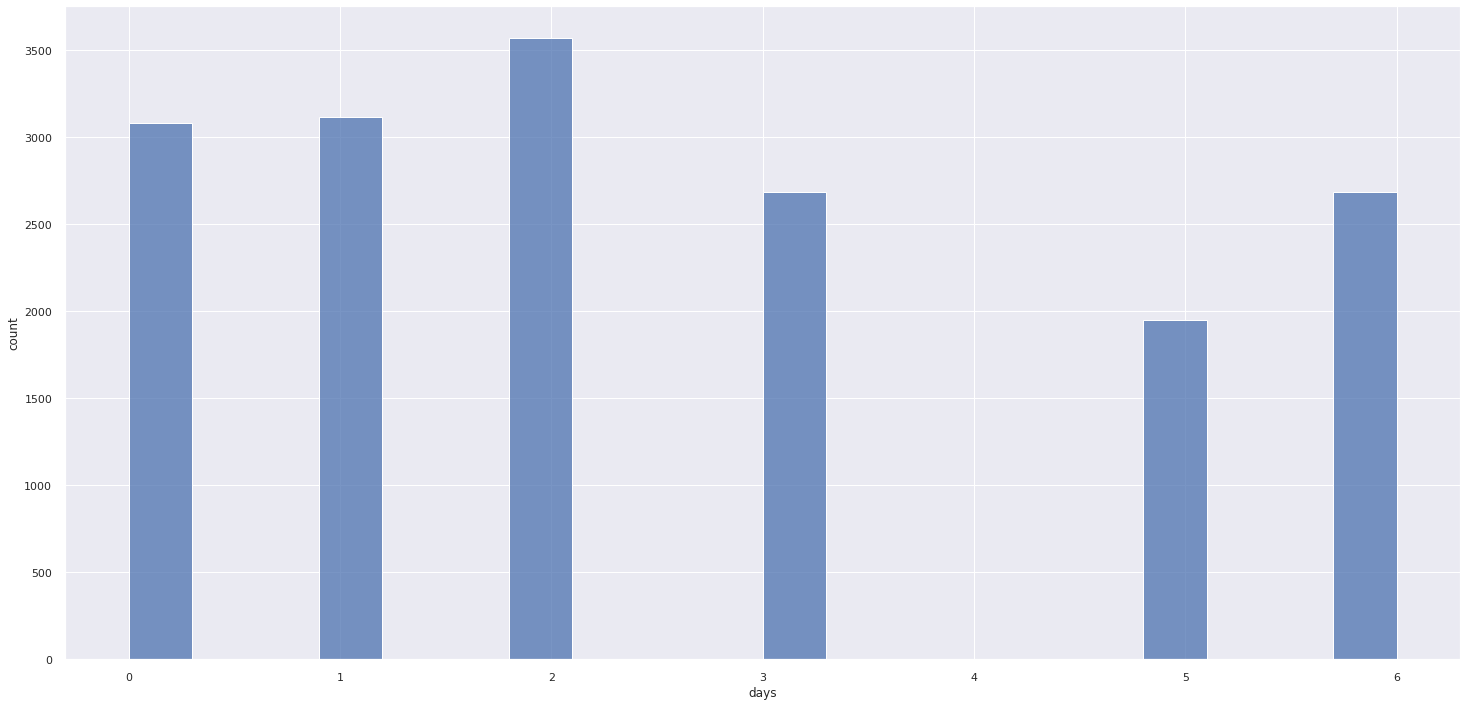

In [59]:
sns.histplot(df4['invoice_week'])
plot_label('', 'days', 'count', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/date.png')

An interesting information, this dataset has no purchases on Friday. 


Day of the week      | Value
---                  | ---
Monday               | 0
Tuesday              | 1
Wednesday            | 2
Thursday             | 3
Friday               | 4
Saturday             | 5
Sunday               | 6

#### 4.3.3 Monetary

In [60]:
df4[df4['monetary'] >= 280206].sample(1)

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
180636,14646,Netherlands,1.000,2076.000,280206.020,134.974,73.000,2076.000,0.206,772.000,2697.466,28.438,2016.000,12.000,6.000


#### 4.3.4 Avg Ticket

In [61]:
df4[df4['avg_ticket'] >= 4453.43]

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
207743,15749,United Kingdom,235.000,10.000,44534.300,4453.430,3.000,10.000,0.031,9014.000,6009.333,3.333,2017.000,1.000,0.000
207748,15749,United Kingdom,235.000,10.000,44534.300,4453.430,3.000,10.000,0.031,9014.000,6009.333,3.333,2017.000,4.000,6.000
222785,12346,United Kingdom,325.000,1.000,77183.600,77183.600,1.000,1.000,1.000,74215.000,74215.000,1.000,2017.000,1.000,0.000
368063,16446,United Kingdom,0.000,3.000,168472.500,56157.500,2.000,3.000,0.010,80995.000,40498.500,1.500,2017.000,5.000,1.000
368065,16446,United Kingdom,0.000,3.000,168472.500,56157.500,2.000,3.000,0.010,80995.000,40498.500,1.500,2017.000,12.000,3.000
385505,15098,United Kingdom,182.000,3.000,39916.500,13305.500,3.000,3.000,3.000,61.000,40.333,1.000,2017.000,6.000,3.000


Customer 1

In [62]:
df3[df3['customer_id'] == 15749]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
52709,15749,2017-01-09,85123A,2.550,1930,United Kingdom,540815
52710,15749,2017-01-09,21175,1.850,2000,United Kingdom,540815
52711,15749,2017-01-09,21108,2.100,3114,United Kingdom,540815
52771,15749,2017-01-09,47556B,2.550,1300,United Kingdom,540818
52772,15749,2017-01-09,48185,6.750,670,United Kingdom,540818
160141,15749,2017-04-16,48185,6.750,-670,United Kingdom,C550456
160142,15749,2017-04-16,47566B,2.550,-1300,United Kingdom,C550456
160143,15749,2017-04-16,85123A,2.550,-1930,United Kingdom,C550456
160144,15749,2017-04-16,21175,1.850,-2000,United Kingdom,C550456
160145,15749,2017-04-16,21108,2.100,-3114,United Kingdom,C550456


Customer 2

In [63]:
df3[df3['customer_id'] == 16446]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
194354,16446,2017-05-16,22980,1.650,1,United Kingdom,553573
194355,16446,2017-05-16,22982,1.250,1,United Kingdom,553573
540421,16446,2017-12-07,23843,2.080,80995,United Kingdom,581483
540422,16446,2017-12-07,23843,2.080,-80995,United Kingdom,C581484


Customer 3

In [64]:
df3[df3['customer_id'] == 15098]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
222670,15098,2017-06-08,22502,4.950,60,United Kingdom,556442
222680,15098,2017-06-08,22502,649.500,60,United Kingdom,556444
222682,15098,2017-06-08,22502,649.500,1,United Kingdom,556446
222692,15098,2017-06-08,22502,4.950,-60,United Kingdom,C556448


#### 4.3.5 Quantity of Products Purchased

Customer 1

In [65]:
df4[df4['quantity_of_products_purchased'] == 7847].sample(1)

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
24009,17841,United Kingdom,1.000,7847.000,40991.570,5.224,124.000,7847.000,0.332,206.000,186.056,63.282,2017.000,6.000,5.000


In [66]:
df3[df3['customer_id'] == 17841].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
278383,17841,2017-07-23,23263,1.250,-10,United Kingdom,C561210
494925,17841,2017-11-21,22339,0.190,-7,United Kingdom,C578280
484964,17841,2017-11-18,23148,0.830,-7,United Kingdom,C577547
440248,17841,2017-11-02,22893,0.420,-6,United Kingdom,C574524
406915,17841,2017-10-17,23322,2.950,-5,United Kingdom,C571838


In [67]:
df3[df3['customer_id'] == 17841].sort_values(by = 'quantity', ascending = False).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
451888,17841,2017-11-07,20668,0.100,288,United Kingdom,575298
277498,17841,2017-07-23,16045,0.040,200,United Kingdom,561113
315623,17841,2017-08-26,20668,0.120,144,United Kingdom,564733
499593,17841,2017-11-22,22161,0.190,128,United Kingdom,578678
221431,17841,2017-06-07,22467,2.100,108,United Kingdom,556245


Customer 2

In [68]:
df4[df4['quantity_of_products_purchased'] == 5675].sample(1)

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
21538,14911,EIRE,1.000,5675.000,143825.060,25.344,201.000,5675.000,0.539,3335.000,399.328,28.234,2017.000,12.000,5.000


In [69]:
df3[df3['customer_id'] == 14911].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
290364,14911,2017-08-02,22950,1.250,-288,EIRE,C562375
290363,14911,2017-08-02,22952,0.420,-240,EIRE,C562375
290359,14911,2017-08-02,23157,1.850,-240,EIRE,C562375
290366,14911,2017-08-02,22910,2.550,-200,EIRE,C562375
290367,14911,2017-08-02,22909,0.720,-192,EIRE,C562375


In [70]:
df3[df3['customer_id'] == 14911].sort_values(by = 'quantity', ascending = False).head(10)

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
408376,14911,2017-10-18,22266,0.190,640,EIRE,571937
321957,14911,2017-08-30,22950,1.250,432,EIRE,565213
321950,14911,2017-08-30,22952,0.420,360,EIRE,565213
461291,14911,2017-11-11,22909,0.720,288,EIRE,575933
282374,14911,2017-07-26,22950,1.250,288,EIRE,561645
290345,14911,2017-08-02,22950,1.250,288,EIRE,562374
446084,14911,2017-11-05,22578,0.290,264,EIRE,574874
408386,14911,2017-10-18,85078,0.190,240,EIRE,571937
408384,14911,2017-10-18,35923,0.390,240,EIRE,571937
461290,14911,2017-11-11,22952,0.420,240,EIRE,575933


Customer 3

In [71]:
df4[df4['quantity_of_products_purchased'] == 4595].sample(1)

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
12193,12748,United Kingdom,0.000,4595.000,33719.730,7.338,209.000,4595.000,0.559,1538.000,123.191,21.986,2017.000,9.000,2.000


In [72]:
df3[df3['customer_id'] == 12748].sort_values(by = 'quantity', ascending = True).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
473393,12748,2017-11-14,22071,0.500,-244,United Kingdom,C576831
473394,12748,2017-11-14,22070,0.500,-234,United Kingdom,C576831
473392,12748,2017-11-14,23055,1.000,-144,United Kingdom,C576831
473391,12748,2017-11-14,23056,1.000,-144,United Kingdom,C576831
473390,12748,2017-11-14,23057,1.000,-144,United Kingdom,C576831


In [73]:
df3[df3['customer_id'] == 12748].sort_values(by = 'quantity', ascending = False).head()

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
460034,12748,2017-11-09,21135,0.200,576,United Kingdom,575894
420214,12748,2017-10-24,72803A,0.500,408,United Kingdom,572881
420216,12748,2017-10-24,72802C,0.500,378,United Kingdom,572881
471162,12748,2017-11-13,22071,0.500,244,United Kingdom,576623
365289,12748,2017-09-26,16218,0.060,240,United Kingdom,568703


#### 4.3.5 Number of returns

Customer 1

In [74]:
df4[df4['quantity_of_returns'] == 80995]

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
368063,16446,United Kingdom,0.000,3.000,168472.500,56157.500,2.000,3.000,0.010,80995.000,40498.500,1.500,2017.000,5.000,1.000
368065,16446,United Kingdom,0.000,3.000,168472.500,56157.500,2.000,3.000,0.010,80995.000,40498.500,1.500,2017.000,12.000,3.000


Customer 2 from avg_ticket analysis

Customer 2

In [75]:
df4[df4['quantity_of_returns'] == 74215]

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
222785,12346,United Kingdom,325.000,1.000,77183.600,77183.600,1.000,1.000,1.000,74215.000,74215.000,1.000,2017.000,1.000,0.000


In [76]:
df3[df3['customer_id'] == 12346]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
61619,12346,2017-01-16,23166,1.040,74215,United Kingdom,541431
61624,12346,2017-01-16,23166,1.040,-74215,United Kingdom,C541433


Customer 3

In [77]:
df4[df4['quantity_of_returns'] == 9014]

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
207743,15749,United Kingdom,235.000,10.000,44534.300,4453.430,3.000,10.000,0.031,9014.000,6009.333,3.333,2017.000,1.000,0.000
207748,15749,United Kingdom,235.000,10.000,44534.300,4453.430,3.000,10.000,0.031,9014.000,6009.333,3.333,2017.000,4.000,6.000


In [78]:
df3[df3['customer_id'] == 15749]

,customer_id,invoice_date,stock_code,unit_price,quantity,country,invoice_no
52709,15749,2017-01-09,85123A,2.550,1930,United Kingdom,540815
52710,15749,2017-01-09,21175,1.850,2000,United Kingdom,540815
52711,15749,2017-01-09,21108,2.100,3114,United Kingdom,540815
52771,15749,2017-01-09,47556B,2.550,1300,United Kingdom,540818
52772,15749,2017-01-09,48185,6.750,670,United Kingdom,540818
160141,15749,2017-04-16,48185,6.750,-670,United Kingdom,C550456
160142,15749,2017-04-16,47566B,2.550,-1300,United Kingdom,C550456
160143,15749,2017-04-16,85123A,2.550,-1930,United Kingdom,C550456
160144,15749,2017-04-16,21175,1.850,-2000,United Kingdom,C550456
160145,15749,2017-04-16,21108,2.100,-3114,United Kingdom,C550456


Customer 1 from avg_ticket analysis

### 4.4 Bivariate Analysis

#### 4.4.1 Pairplot

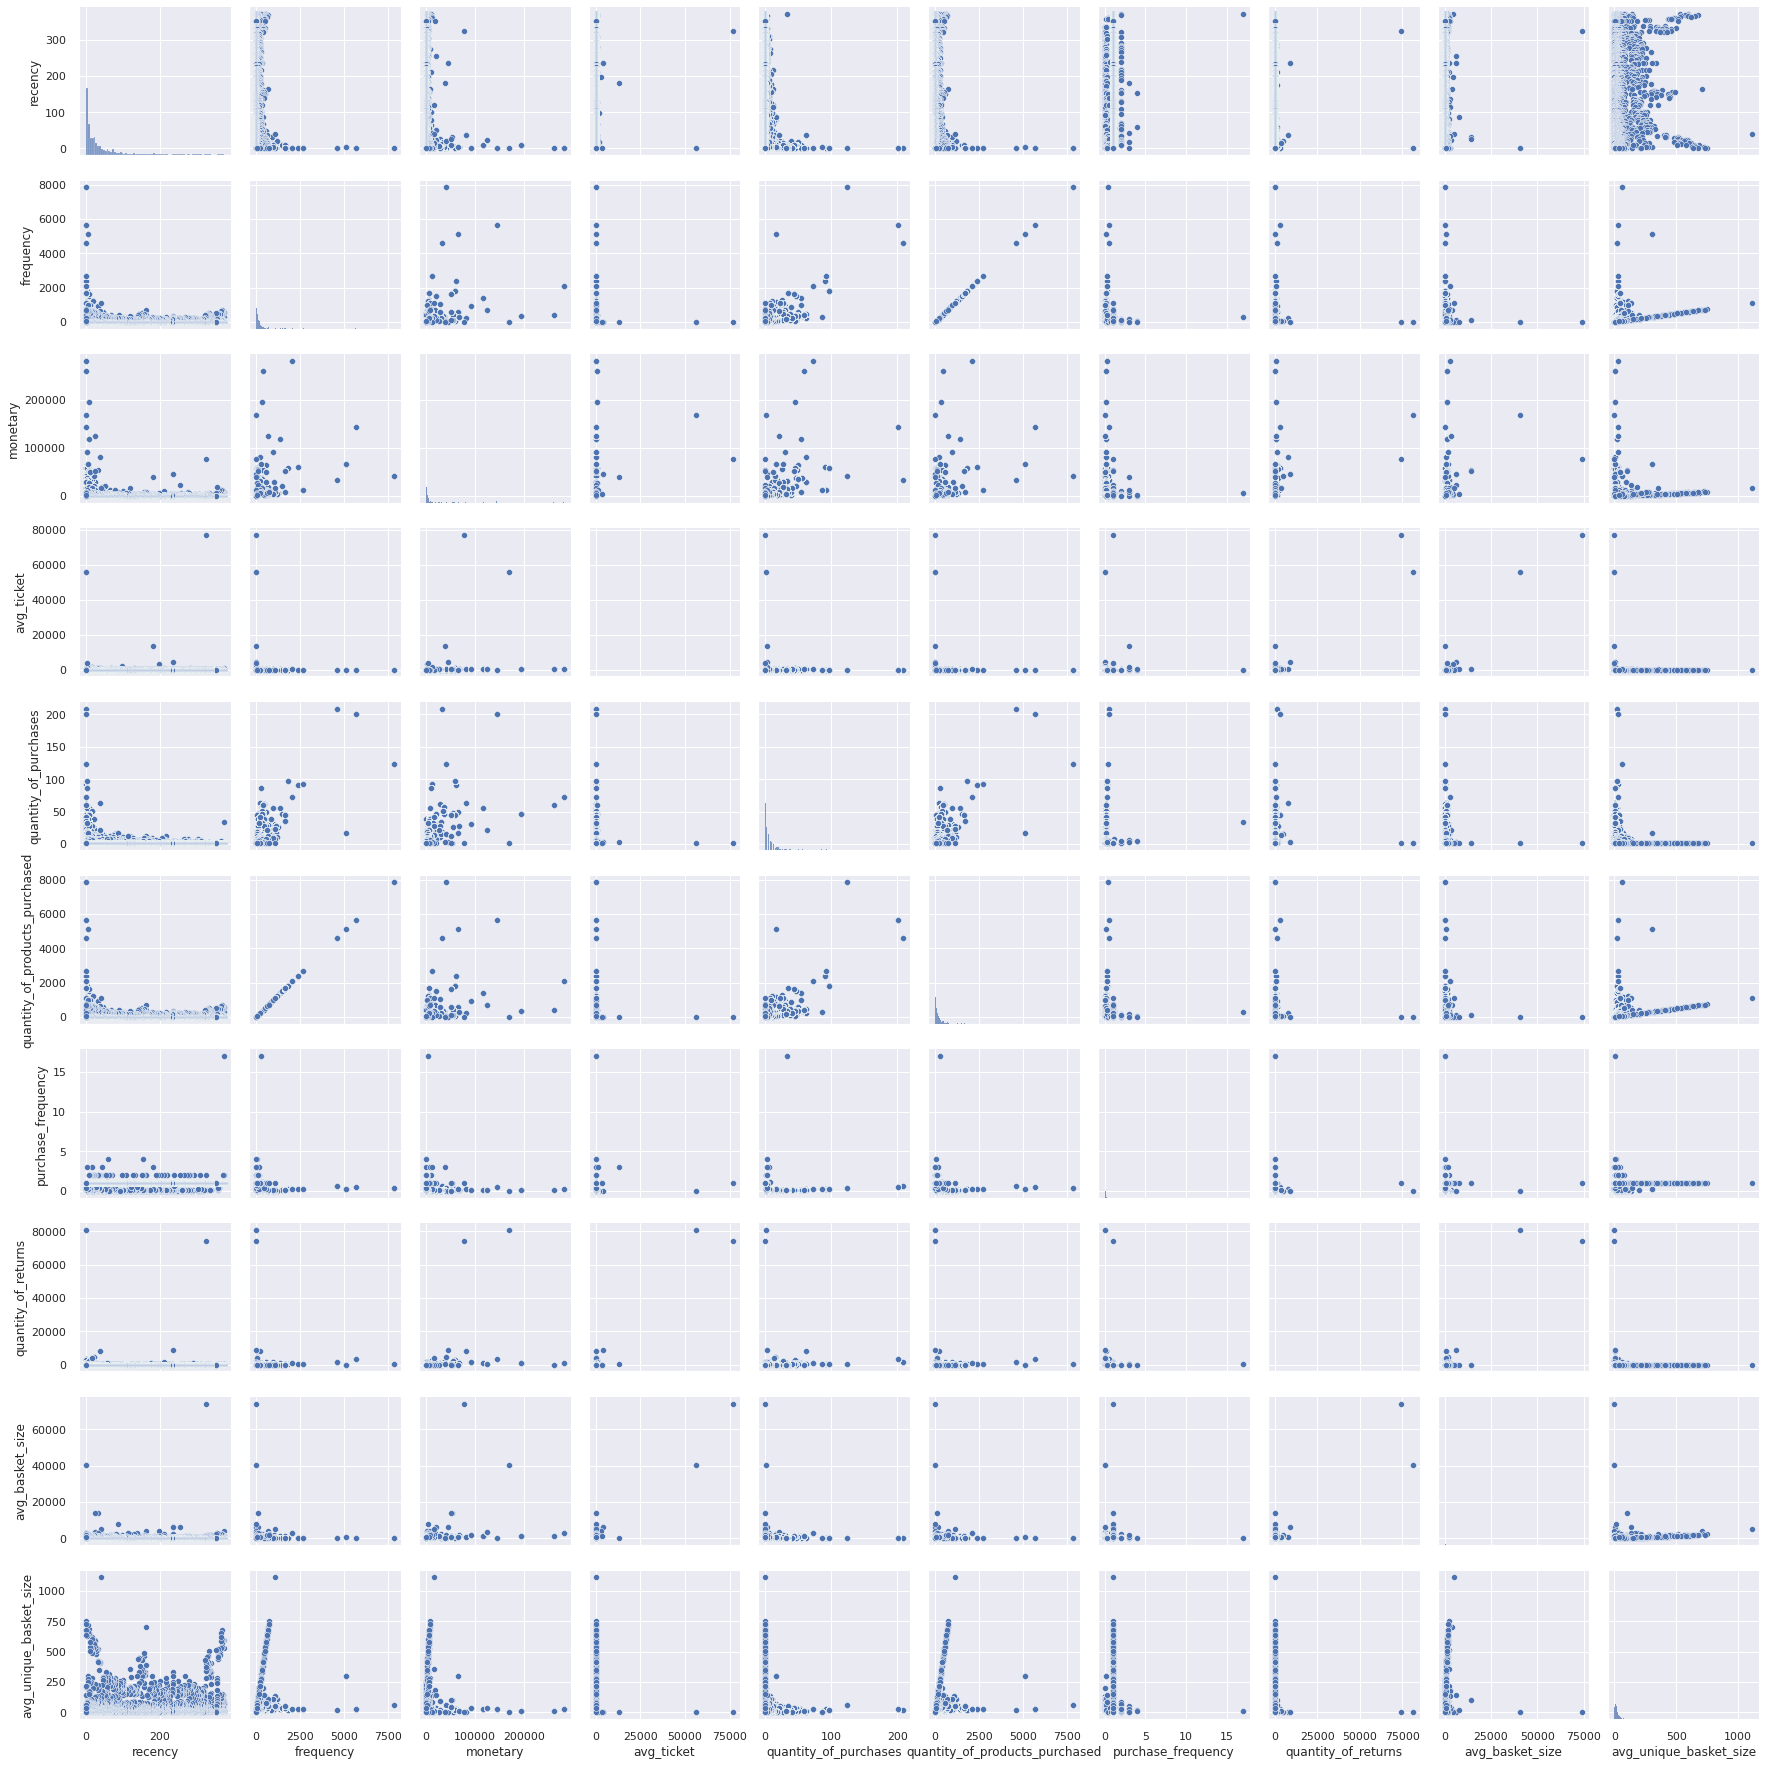

In [79]:
# pairplot
drop_cols = ['customer_id', 'invoice_year', 'invoice_month', 'invoice_week']
df4_pairplot = df4.drop(drop_cols, axis = 1)
sns.pairplot(df4_pairplot);

# saving figure
plt.savefig(homepath + 'reports/figures/pairplot.png')

#### 4.4.2 The customers with highest recency are from the United Kingdom.
**FALSE** The customer with highest recency aren't from the UK.

In [80]:
rfm_country = df4[['customer_id', 'country', 'recency', 'frequency', 'monetary']]
rfm_country['country'] = rfm_country['country'].apply(lambda x: x if x == 'United Kingdom' or x == 'Germany' 
                                                                                           or x == 'France' 
                                                                                           or x == 'EIRE' 
                                                                                           or x == 'Spain' 
                                                                                           or x == 'Netherlands'
                                                                  else 'Other countries')
rfm_country = rfm_country[rfm_country['customer_id'] < 18000]

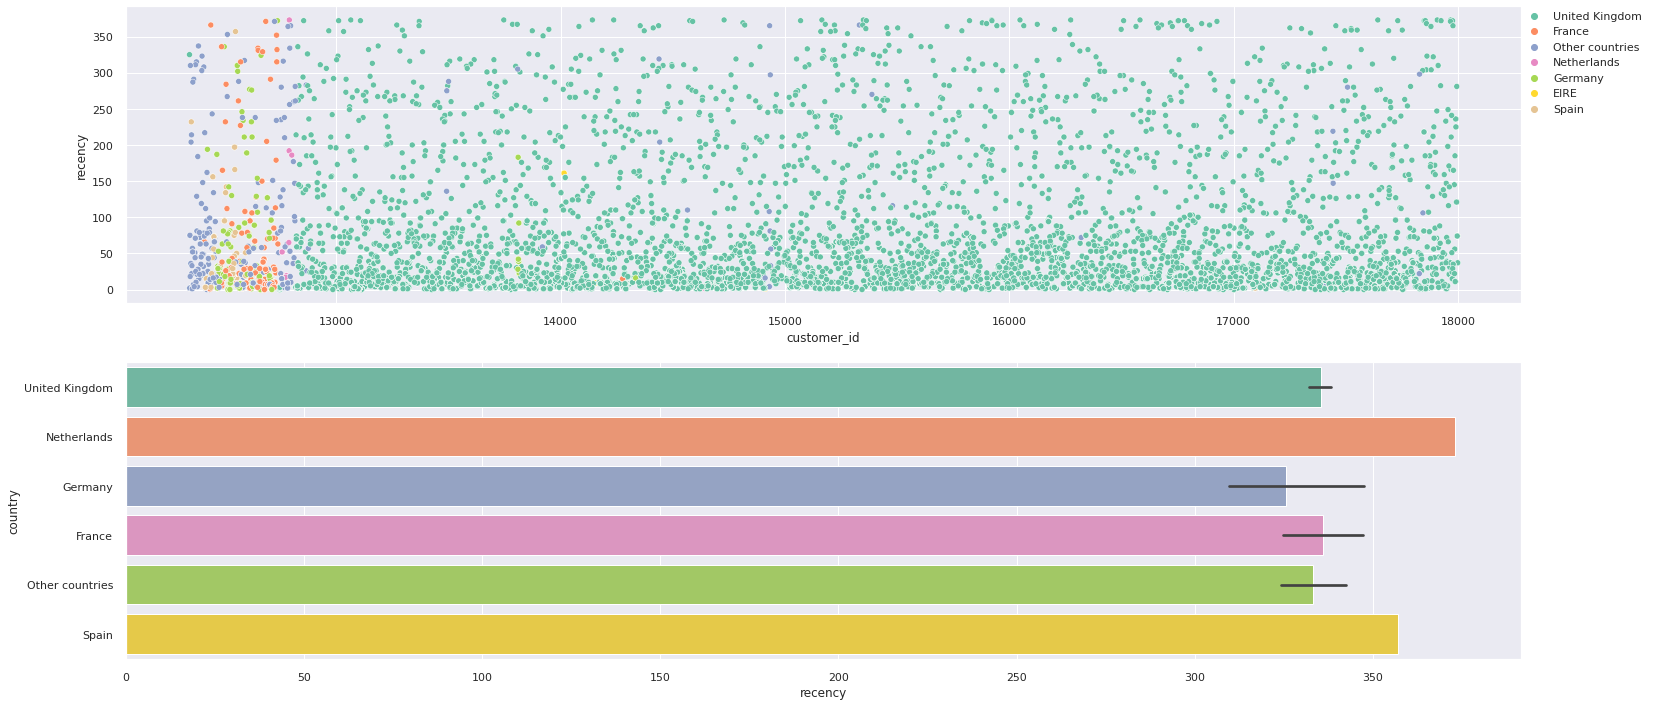

In [81]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# recency
ax = sns.scatterplot(x = 'customer_id', y = 'recency',   data = rfm_country, hue = 'country', palette = 'Set2', ax = ax1)
plot_label('', 'customer id', 'recency', 12);
ax.legend(bbox_to_anchor = (1.09, 1), loc = 'upper right', borderaxespad = 0.)

aux = rfm_country[rfm_country['recency'] >= 300]
ax = sns.barplot(x = 'recency', y = 'country', data = aux, palette = 'Set2', ax = ax2)
plot_label('', 'recency', 'country', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/country_recency.png')

#### 4.4.3 The customers with highest frequency are from the United Kingdom.
**FALSE** The customer with highest frequency aren't from the UK.

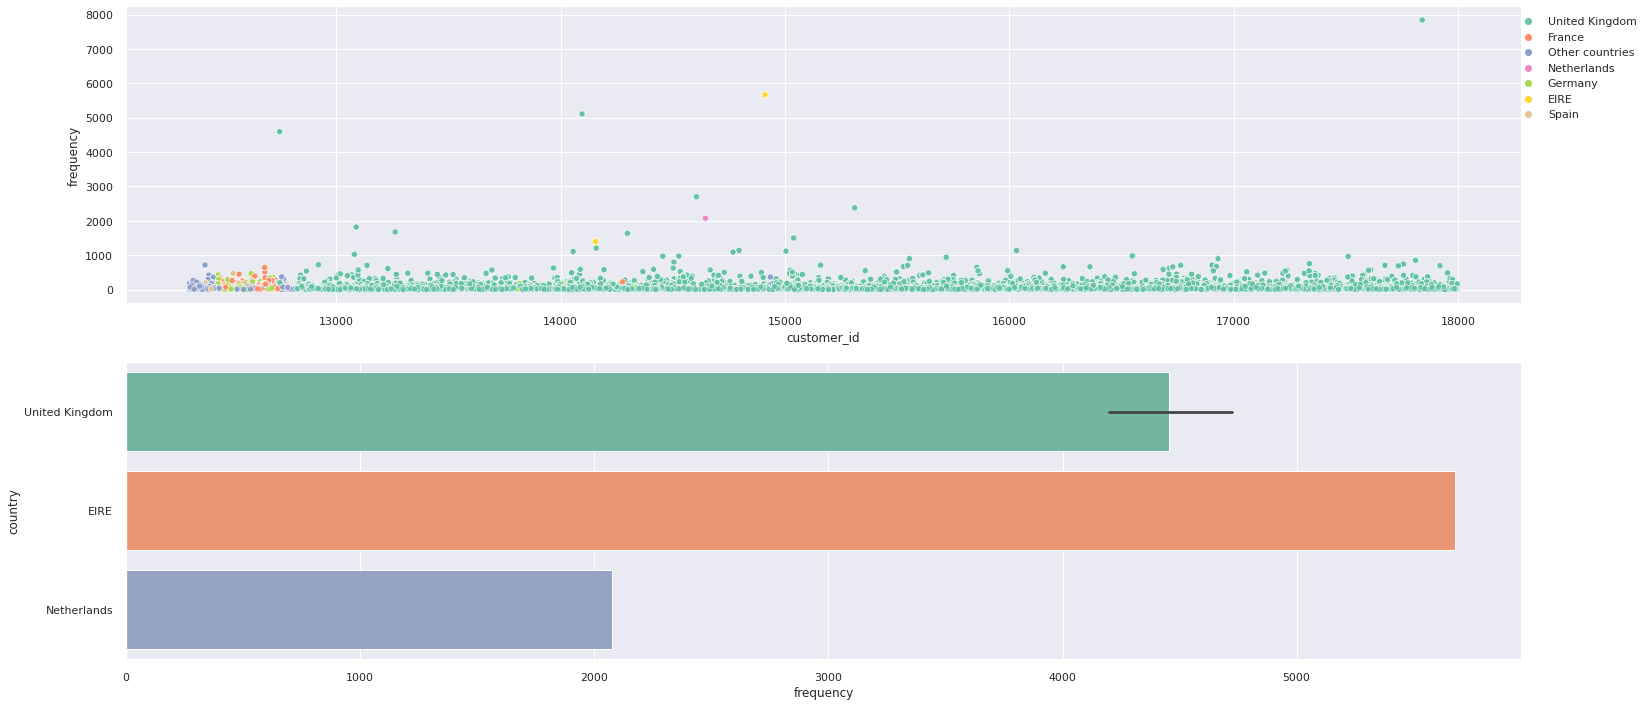

In [82]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# frequency
ax = sns.scatterplot(x = 'customer_id', y = 'frequency',   data = rfm_country, hue = 'country', palette = 'Set2', ax = ax1)
plot_label('', 'customer id', 'frequency', 12);
ax.legend(bbox_to_anchor = (1.09, 1), loc = 'upper right')


aux = rfm_country[rfm_country['frequency'] >= 2000]
ax = sns.barplot(x = 'frequency', y = 'country', data = aux, palette = 'Set2', ax = ax2)
plot_label('', 'frequency', 'country', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/country_frequency.png')

#### 4.4.4 The customers with highest monetary value are from the United Kingdom.
**FALSE** The customer with highest monetary value aren't from the UK.

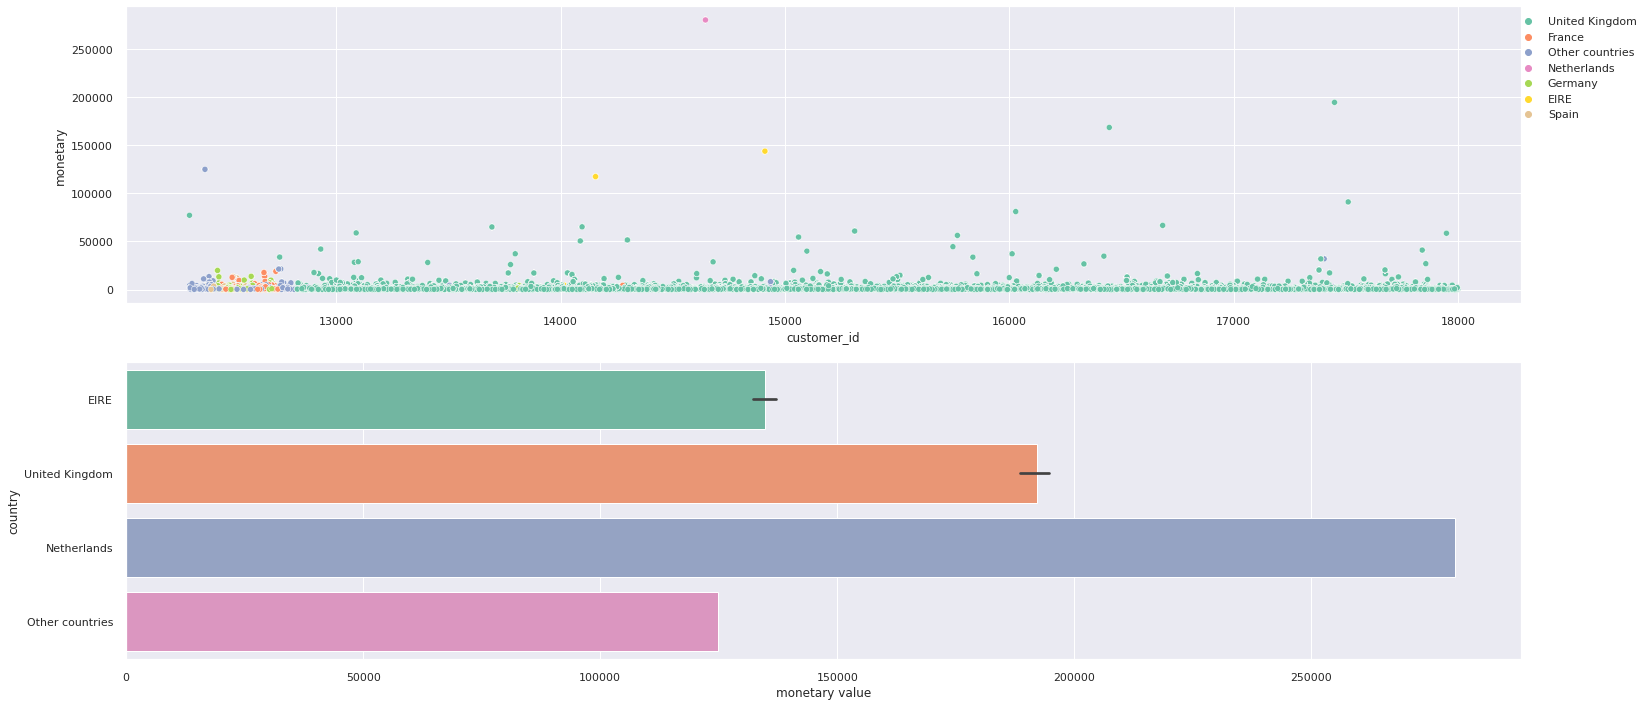

In [83]:
# creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# monetary
ax = sns.scatterplot(x = 'customer_id', y = 'monetary',   data = rfm_country, hue = 'country', palette = 'Set2', ax = ax1)
plot_label('', 'customer id', 'monetary value', 12);
ax.legend(bbox_to_anchor = (1.09, 1), loc = 'upper right')

aux = rfm_country[rfm_country['monetary'] >= 100000]
ax = sns.barplot(x = 'monetary', y = 'country', data = aux, palette = 'Set2', ax = ax2)
plot_label('', 'monetary value', 'country', 12);

# saving figure
plt.savefig(homepath + 'reports/figures/country_monetary.png')

### 4.5 Multivariate Analysis

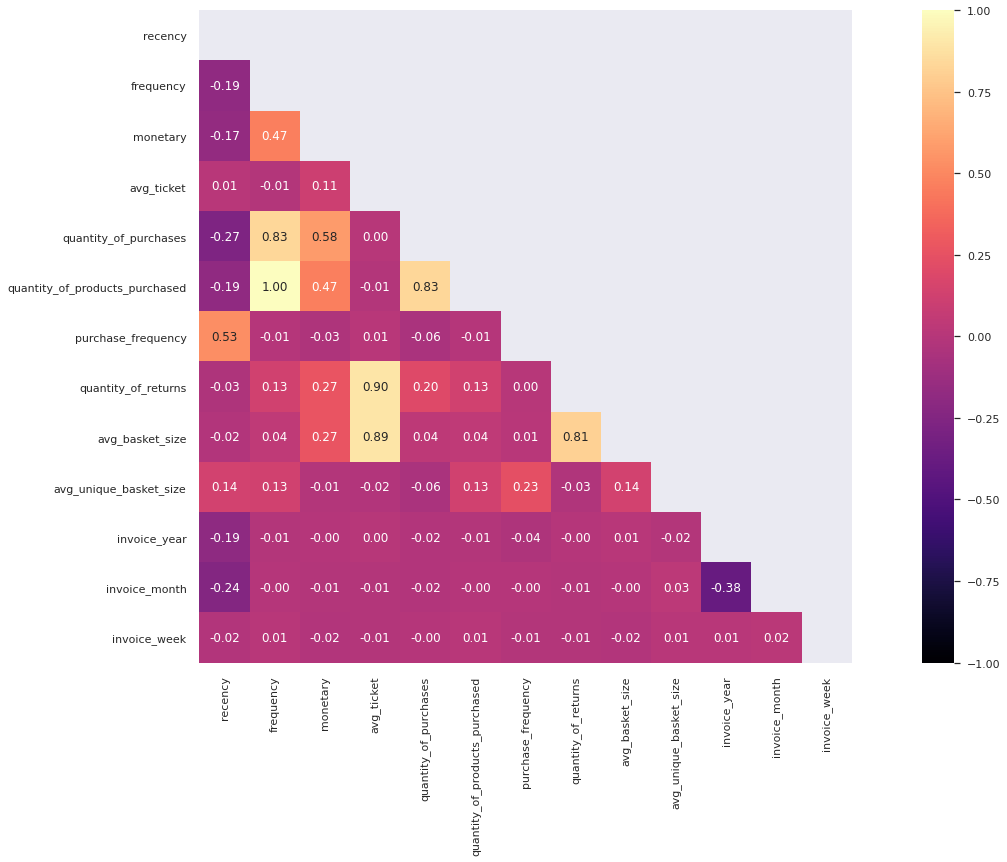

In [84]:
# correlation
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(columns='customer_id')
correlation = num_attributes.corr(method='pearson')

# mask
mask = np.zeros_like(correlation)
mask = np.triu(np.ones_like(correlation, dtype=np.bool))

# plot
ax = sns.heatmap(correlation, mask = mask, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

# saving figure
plt.savefig(homepath + 'reports/figures/numerical_multivariate.png')

### 4. Save State

In [85]:
pickle.dump(df4, open(homepath + 'data/processed/df4.pkl', 'wb'))

## 5.0 DATA PREPARATION 

- **Tasks**
    - Dataset Checkpoint
    - RFM Scale
    - Save State

### 5.1 Dataset Checkpoint

In [86]:
df5 = pickle.load(open(homepath + 'data/processed/df3.pkl', 'rb'))

In [87]:
df5.head()

,customer_id,country,recency,frequency,monetary,avg_ticket,quantity_of_purchases,quantity_of_products_purchased,purchase_frequency,quantity_of_returns,avg_basket_size,avg_unique_basket_size,invoice_year,invoice_month,invoice_week
0,17850,United Kingdom,372.000,297.000,5391.210,18.152,34.000,297.000,17.000,40.000,50.971,8.735,2016.000,11.000,1.000
1,17850,United Kingdom,372.000,297.000,5391.210,18.152,34.000,297.000,17.000,40.000,50.971,8.735,2016.000,11.000,1.000
2,17850,United Kingdom,372.000,297.000,5391.210,18.152,34.000,297.000,17.000,40.000,50.971,8.735,2016.000,11.000,1.000
3,17850,United Kingdom,372.000,297.000,5391.210,18.152,34.000,297.000,17.000,40.000,50.971,8.735,2016.000,11.000,1.000
4,17850,United Kingdom,372.000,297.000,5391.210,18.152,34.000,297.000,17.000,40.000,50.971,8.735,2016.000,11.000,1.000


### 5.2 RFM

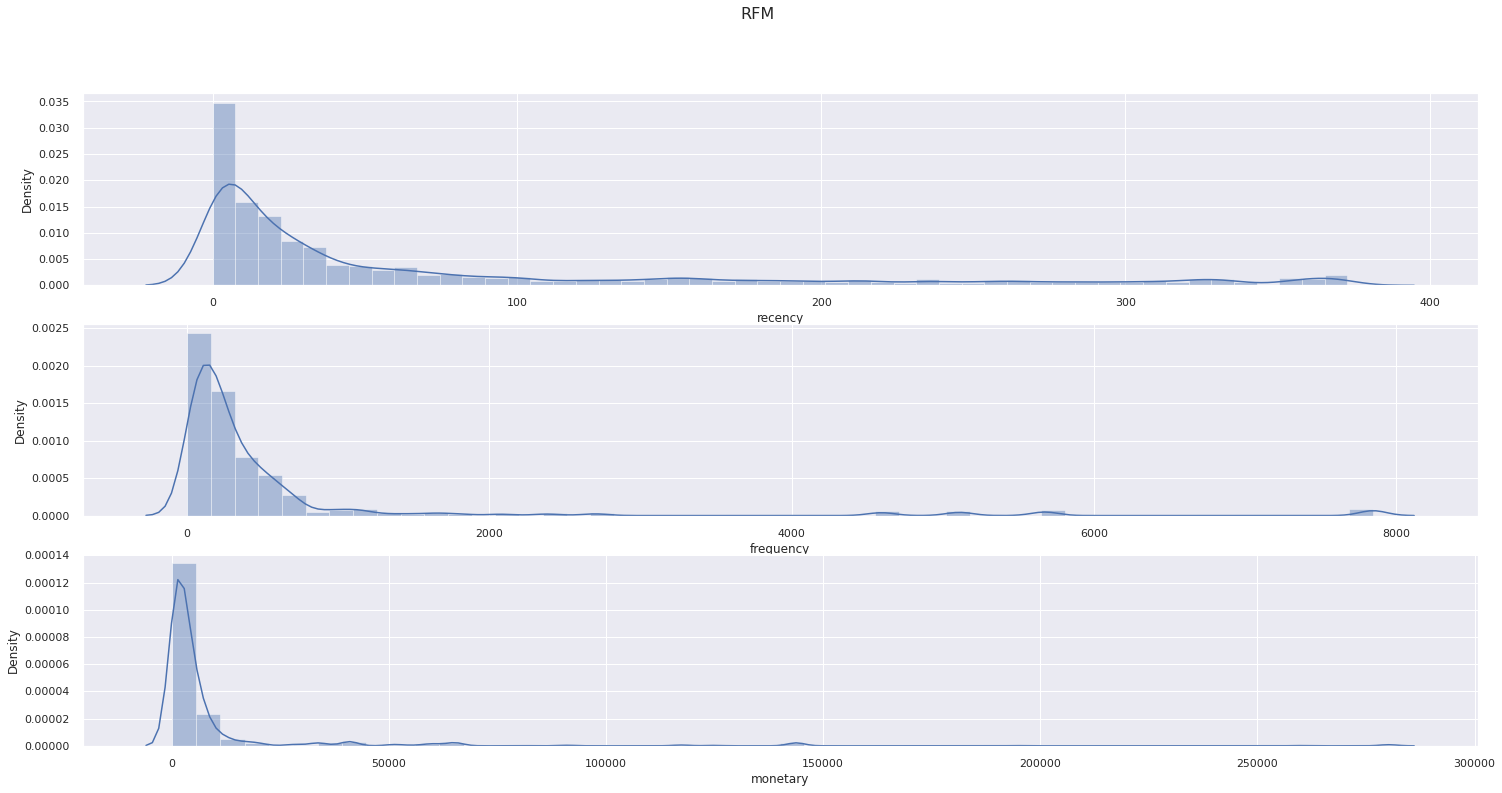

In [88]:
# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('RFM', fontsize=16)

ax = sns.distplot(df5['recency'], ax = ax1)
ax = sns.distplot(df5['frequency'], ax = ax2)
ax = sns.distplot(df5['monetary'], ax = ax3)

# saving figure
plt.savefig(homepath + 'reports/figures/rfm.png')

### 5.3 Standard Scaler

In [89]:
# standard scalaer
ss = pp.StandardScaler()

df5['recency'] = ss.fit_transform(df5[['recency']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['monetary'] = ss.fit_transform(df5[['monetary']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

### 5.4 RFM with Standard Scaler

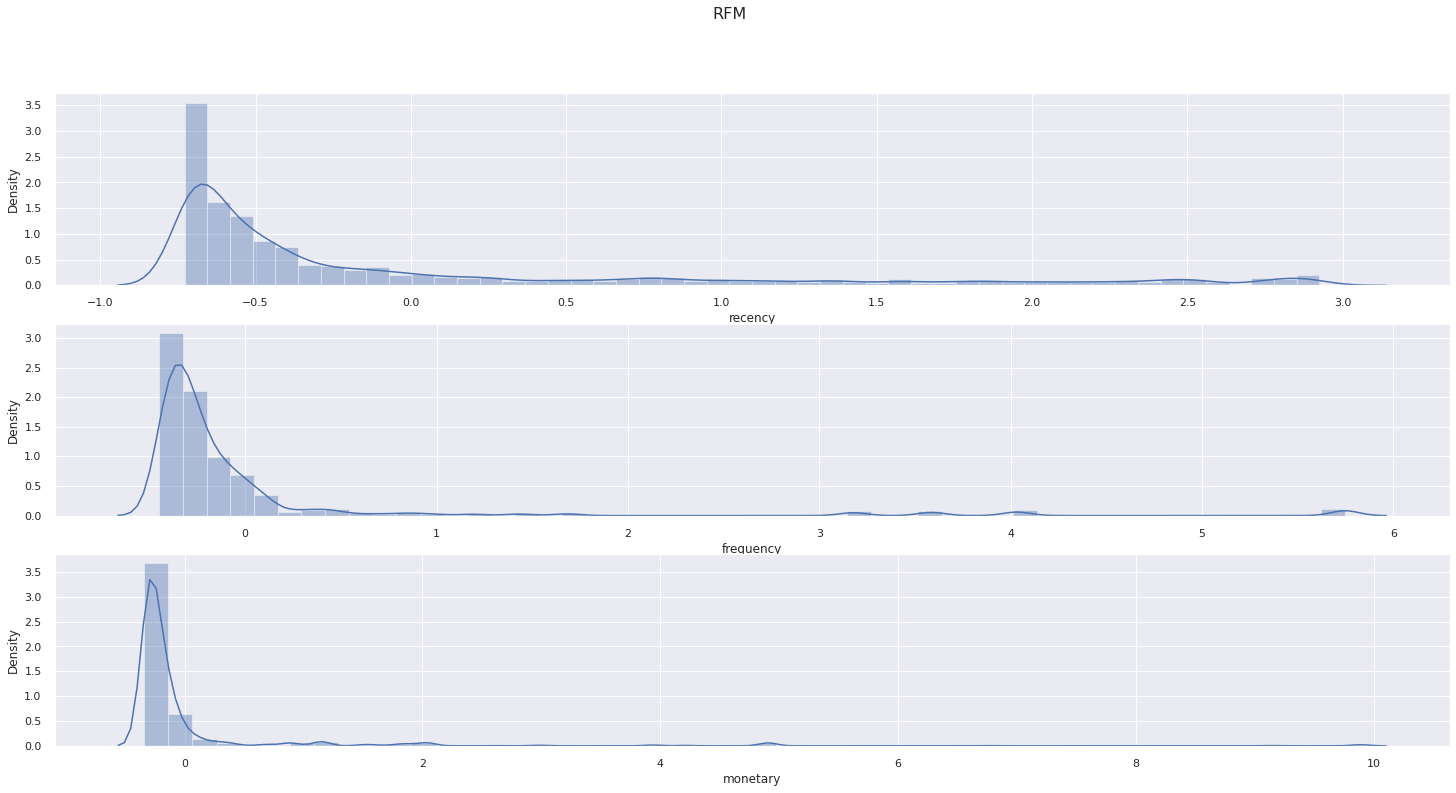

In [90]:
# creating subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('RFM', fontsize=16)

ax = sns.distplot(df5['recency'], ax = ax1)
ax = sns.distplot(df5['frequency'], ax = ax2)
ax = sns.distplot(df5['monetary'], ax = ax3)

# saving figure
plt.savefig(homepath + 'reports/figures/rfm_ss.png')

### 5.5 Save State

In [91]:
pickle.dump(df5, open(homepath + 'data/processed/df5.pkl', 'wb'))

## 6. FEATURE SELECTION

- **Tasks**
    - Dataset Checkpoint
    - Features
    - Save State

### 6.1 Dataset Checkpoint

In [92]:
df6 = pickle.load(open(homepath + 'data/processed/df5.pkl', 'rb'))

### 6. Save State

In [93]:
pickle.dump(df6, open(homepath + 'data/processed/df6.pkl', 'wb'))

## 7.0 HYPERPARAMETER FINE TUNING

- **Tasks**
    - Dataset Checkpoint
    - Clusters
    - WSS
    - Silhouette

### 7.1 Dataset Checkpoint

In [94]:
df4.columns

Index(['customer_id', 'country', 'recency', 'frequency', 'monetary',
       'avg_ticket', 'quantity_of_purchases', 'quantity_of_products_purchased',
       'purchase_frequency', 'quantity_of_returns', 'avg_basket_size',
       'avg_unique_basket_size', 'invoice_year', 'invoice_month',
       'invoice_week'],
      dtype='object')

In [95]:
cols = ['customer_id', 'country', 'quantity_of_purchases', 'quantity_of_products_purchased', 'purchase_frequency', 
        'quantity_of_returns', 'avg_basket_size', 'avg_unique_basket_size', 'invoice_year', 'invoice_month', 'invoice_week']
        
X = df6.drop(columns = cols)
X.columns

Index(['recency', 'frequency', 'monetary', 'avg_ticket'], dtype='object')

### 7.2 Clusters

In [96]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9]

### 7.3 WSS

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

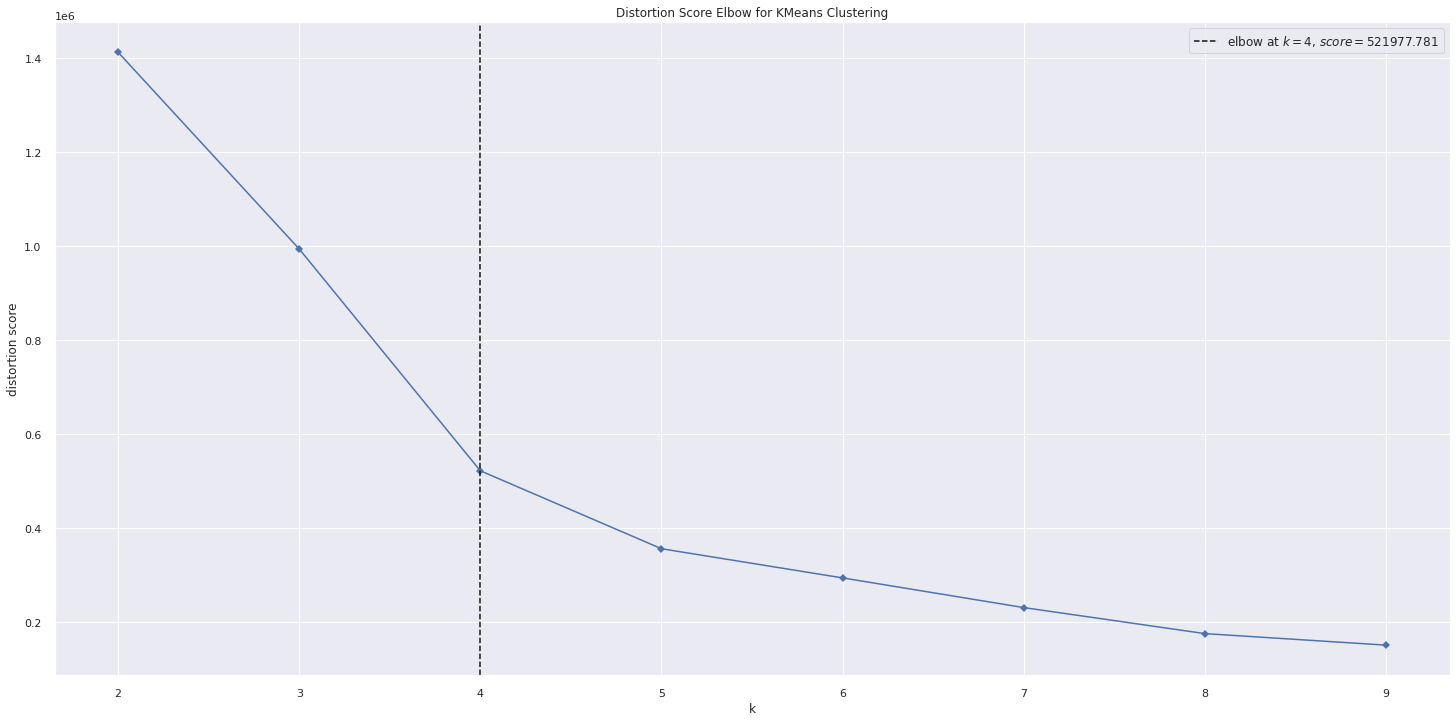

In [97]:
kelbow_visualizer = KElbowVisualizer(KMeans(), k = clusters, timings = False);
kelbow_visualizer.fit(X);
kelbow_visualizer.show(outpath = homepath + 'reports/figures/wss.png')

### 7.4 Silhouette

#### 7.4.1 Silhouette Elbow

In [98]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric = 'silhouette', timings = False);
kmeans.fit(X);
kmeans.show(outpath = homepath + 'reports/figures/silhouette_elbow.png')

KeyboardInterrupt: 

#### 7.4.2 Silhouette Analysis

In [ ]:
n_subplots = int(len(clusters)/2)

fig, ax = plt.subplots(n_subplots, 2, figsize = (25, 30))

for k in clusters:
    km = KMeans(n_clusters = k, init = 'random', n_init = 10, max_iter = 100, random_state = seed)
    q, mod = divmod(k, 2)
    
    silhouette_visualizer = SilhouetteVisualizer(km, colors = 'pastel', ax = ax[q-1][mod])
    silhouette_visualizer.fit(X)
    silhouette_visualizer.finalize()
    
# saving figure
plt.savefig(homepath + 'reports/figures/silhouette_analysis.png')

## 8.0 MODEL TRAINING

- **Tasks**
    - Kmeans
    - Cluster Validation

### 8.1 K-Means

In [ ]:
# model definition
k = 4
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [ ]:
# WSS
print(f"The WSS value is: {kmeans.inertia_}")

# Silhouette Score
print(f"The Silhouette Value is: {silhouette_score(X, labels, metric = 'euclidean')}")

The WSS value is: 70430926.73991333
The Silhouette Value is: 0.7177437760587354


## 9.0 CLUSTER ANALYSIS

- **Tasks**
    - Dataset Checkpoint
    - Visualization for Inspection
    - Cluster Profile

### 9.1 Dataset Checkpoint

In [ ]:
df9 = pickle.load(open(homepath + 'data/processed/df6.pkl', 'rb'))
df9['cluster'] = labels

In [ ]:
df9.head()

,customer_id,recency,frequency,monetary,avg_ticket,quantity_of_purcheses,quantity_of_products purchesed,purchase_frequency,cluster
0,17850,2.288,0.984,0.444,-0.029,297.000,297.000,17.000,3
1,13047,-0.769,0.384,0.173,-0.028,172.000,172.000,0.029,3
2,12583,-1.029,0.744,0.681,-0.020,247.000,247.000,0.040,3
3,13748,-0.195,-0.308,-0.114,-0.016,28.000,28.000,0.018,1
4,15100,1.938,-0.428,-0.123,0.185,3.000,3.000,0.073,1


### 9.2 Visualization Inspection

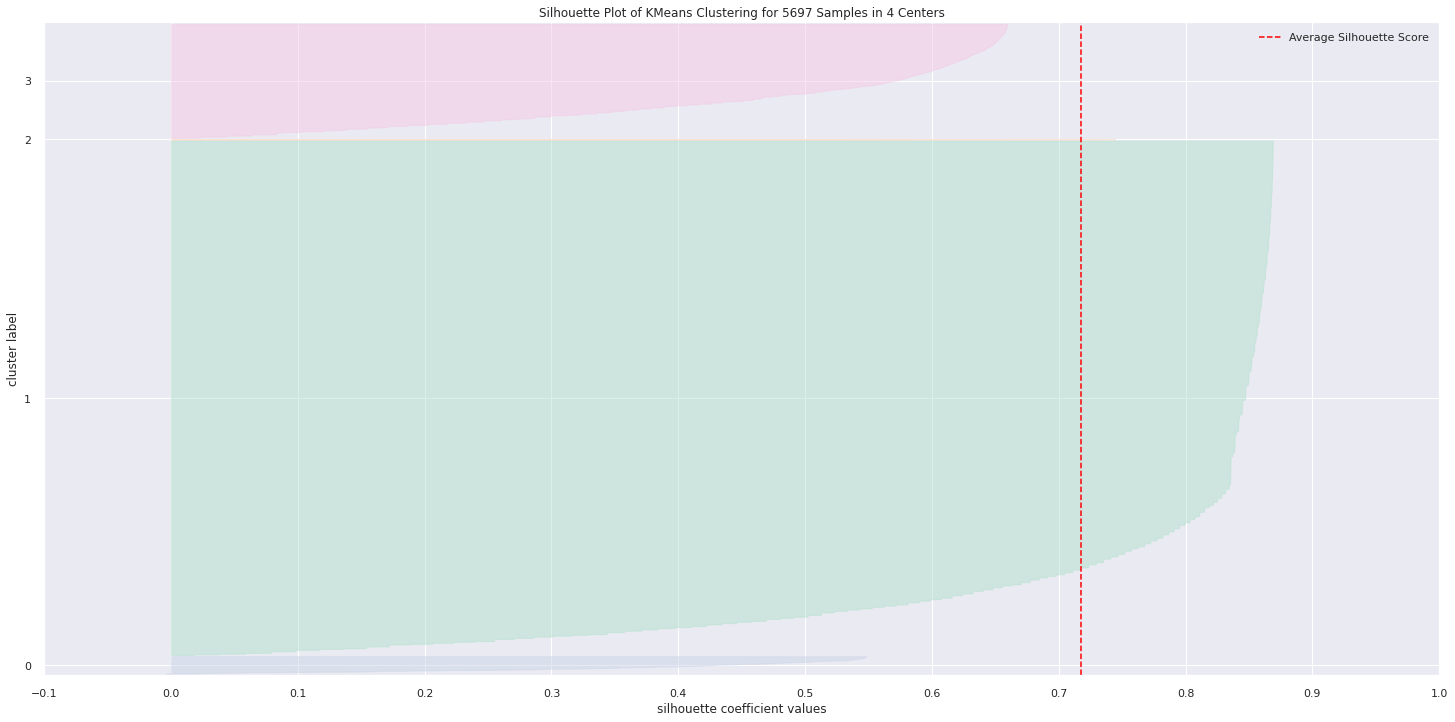

In [ ]:
cluster_viz = SilhouetteVisualizer(kmeans, colors = 'pastel')
cluster_viz.fit(X)
cluster_viz.finalize()

# saving figure
plt.savefig(homepath + 'reports/figures/cluster.png')

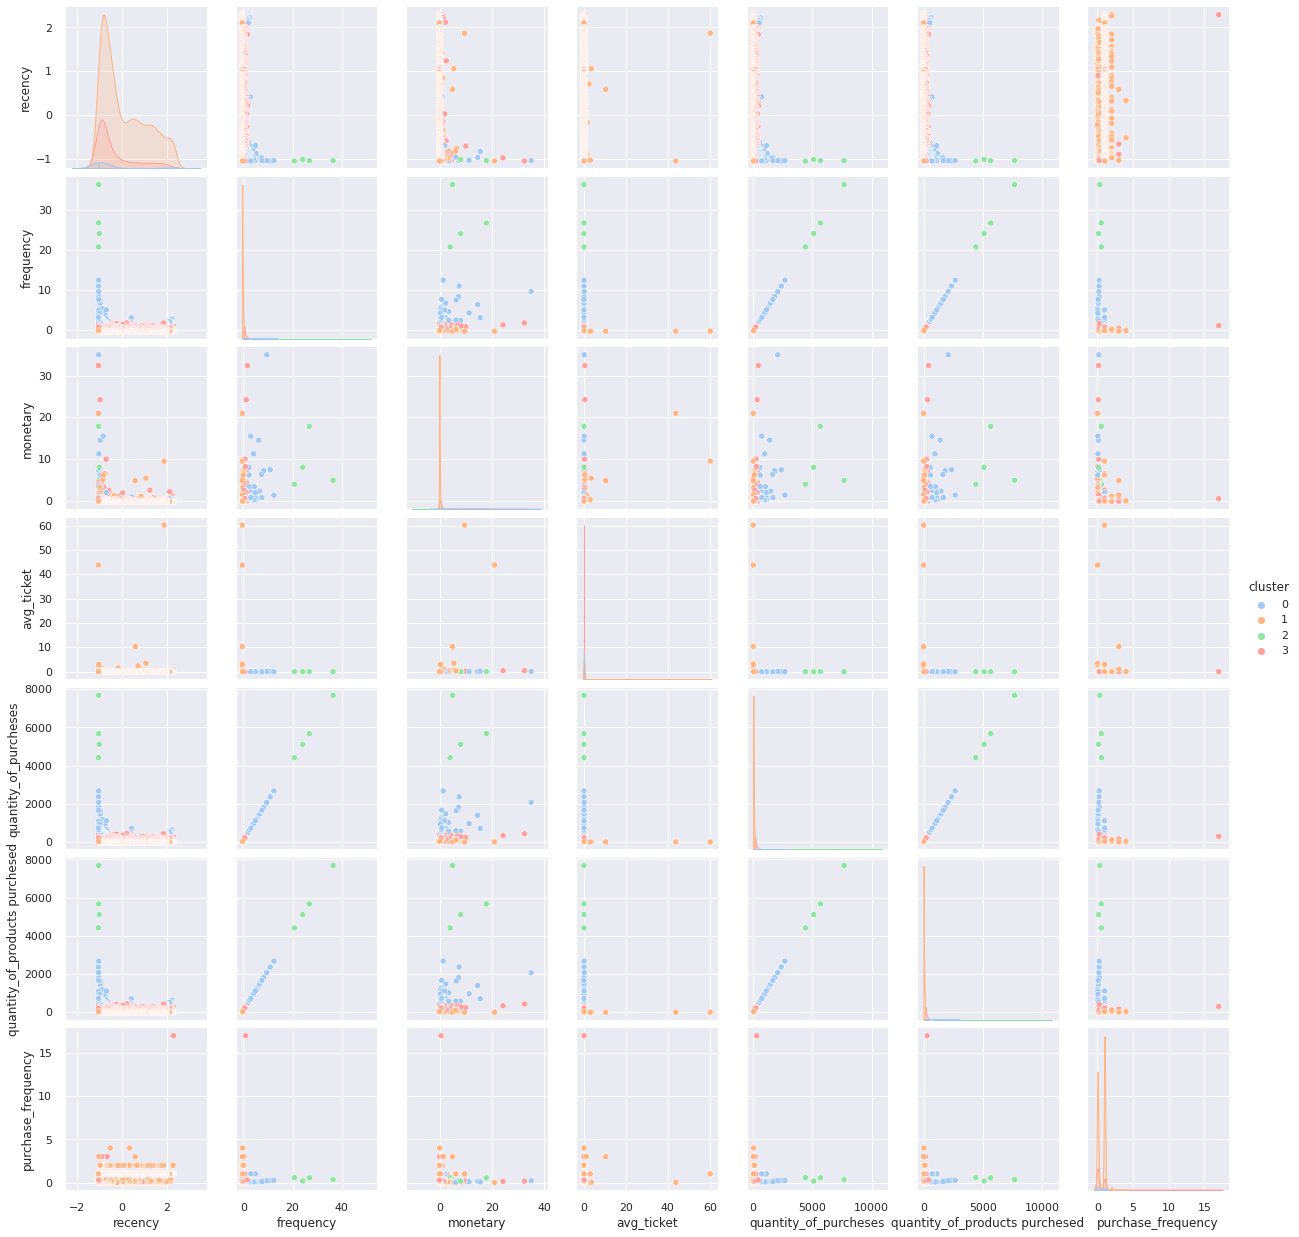

In [ ]:
df_viz = df9.drop(columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster', palette='pastel');

# saving figure
plt.savefig(homepath + 'reports/figures/df_viz.png')

In [ ]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

In [ ]:
## embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

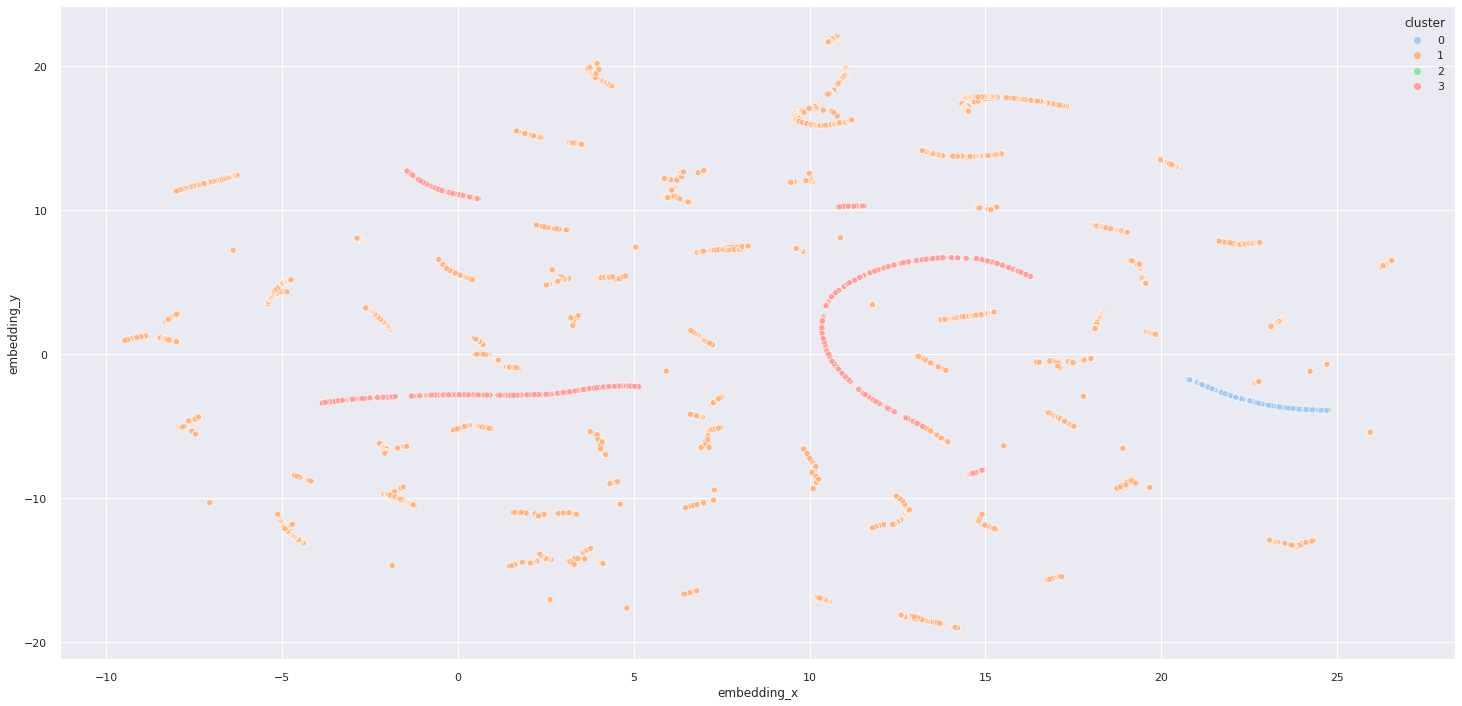

In [ ]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('pastel', len(df_viz['cluster'].unique())),
               data=df_viz);

# saving figure
plt.savefig(homepath + 'reports/figures/umap.png')

### 9.3 Cluster Profile

In [ ]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# avg_recency
df_avg_recency = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# avg_frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

#avg_monetary
df_avg_monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, how='inner', on='cluster')

# avg_ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,recency,frequency,monetary,avg_ticket
0,0,154,2.703,-0.490,2.850,1.331,-0.030
1,1,4533,79.568,0.092,-0.261,-0.116,0.007
2,2,4,0.070,-1.033,27.019,8.639,-0.033
3,3,1006,17.658,-0.334,0.634,0.285,-0.029


#### 9.3.1 Report

# TODO: fix these values

- **Cluster 1 (Insiders)**
    - Number of customers: 13 (0.3% of customers)
    - Average Recency: 
    - Average Frequency:
    - Average Monetary:
- **Cluster 2**
    - Number of customers: 1078 (24.9% of customers)
    - Average Recency: 
    - Average Frequency:
    - Average Monetary:
- **Cluster 3**
    - Number of customers: 3240 (74.8% of customers)
    - Average Recency: 
    - Average Frequency:
    - Average Monetary:

## 10. DEPLOY